# **Сборный проект-2. Оптимизация управления персоналом.**


## Описание проекта.

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён.

Задачи:

  - построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.
  - построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

## Настройка окружения

### Библиотеки

In [1]:
!pip install phik==0.10.0 -q
!pip install shap -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.8.3 requires phik<0.13,>=0.11.1, but you have phik 0.10.0 which is incompatible.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import phik
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder,
    MinMaxScaler,
)
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyRegressor 
from sklearn.dummy import DummyClassifier
import shap
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

### Функции

#### Функция изучения общих сведений от датафреймах

In [3]:
# функция изучения сведений по датафреймам
def data_exam(df):
    df.info()
    print('*' * 70)
    print('Размерность таблицы:' + '\n', df.shape)
    print('*' * 70)
    display(df.head())
    print('*' * 70)
    print('Количество пропусков:' + '\n', df.isna().sum())
    print('*' * 70)
    print('Названия столбцов:' + '\n', df.columns)
    print('*' * 70)
    print('Количество явных дубликатов:' + '\n', df.duplicated().sum())
    print('*' * 70)
    print('Количество неявных дубликатов по столбцу "id":' + '\n', df.duplicated(subset=['id']).sum())
    print('*' * 70)
    print('Уникальные значения в нечисловых столбцах')
    print('-' * 70)
    list_object = []
    list_num = []
    for column in df.columns:
        if df[column].dtype == 'object':
            list_object.append(column)
        else:
            list_num.append(column)
    for value in list_object:
        print('Столбец', value, ':', df[value].unique())
    list_num.remove('id')
    print('*' * 70)
    print('Числовые столбцы')
    for i in list_num:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
        ax1.hist(df[i], bins=10);
        ax1.set_title(i)
        ax1.set_xlabel('Значения')
        ax1.set_ylabel('Частота')
        ax2.boxplot(df[i]);
        ax2.set_title(i)
        plt.show()

##### Функция обработки пробелов

In [4]:
# функция обработки пробелов
def space_to_nan(df, list_columns):
    for column in list_columns:
        print('Столбец', column)
        print('-' * 70)
        print('До обработки:')
        print('Количество пробелов:', len(df.loc[X_test[column] == ' ']))
        print('Количество NaN:', len(df.loc[X_test[column].isna()]))
        print('-' * 70)
        df[column] = df[column].replace(r'^\s*$', np.nan, regex=True)
        print('После обработки:')
        print('Количество пробелов:', len(df.loc[X_test[column] == ' ']))
        print('Количество NaN:', len(df.loc[X_test[column].isna()]))
        print('*' * 70)

##### Функция отрисовки двух наложенных диаграмм

In [5]:
def overlay_hist(df_1, df_2, u_x, u_labels, u_xlabel, u_title):
    sns.histplot(df_1,  x=u_x, stat='density', common_norm=False, color='green', kde=True)
    sns.histplot(df_2,  x=u_x, stat='density', common_norm=False, color='red', kde=True)
    labels= u_labels
    plt.xlabel(u_xlabel)
    plt.ylabel('Плотность')
    plt.legend(labels)
    plt.gcf().set_size_inches(15, 8)
    plt.title(u_title);

##### Функция отрисовки двух наложенных барплотов

In [6]:
def bar_count(df_1, df_2, u_x, u_labels, u_xlabel, u_title):
    df_1[u_x].value_counts().sort_index(ascending=True).plot(
        kind='bar', edgecolor='black', alpha = 1, color='green')
    df_2[u_x].value_counts().sort_index(ascending=True).plot(
        kind='bar', edgecolor='black', alpha = 1, color='red')
    labels= u_labels
    plt.xlabel(u_xlabel)
    plt.ylabel('Количество')
    plt.legend(labels)
    plt.gcf().set_size_inches(15, 8)
    plt.title(u_title);

##### Функция отрисовки двух пайплотов

In [7]:
def pie_two_samples(df_1,df_2,u_title,u_ylabel, column):
    print(' '*40 + u_title)
    for i in column:
        fig, axes = plt.subplots(1, 2, figsize=(15,10))
        t1=df_1.pivot_table(index=i, values='id', aggfunc='count')
        t2=df_2.pivot_table(index=i, values='id', aggfunc='count')
        labels=t1.index.unique()
        axes[0].pie(t1['id'], autopct='%1.0f%%', labels=labels)
        axes[0].set(ylabel=u_ylabel, title='Тренировочная');
        axes[1].pie(t2['id'], autopct='%1.0f%%', labels=labels);
        axes[1].set(ylabel=u_ylabel, title='Тестовая');
        plt.legend(bbox_to_anchor=(1, 0.6));
        plt.show()

##### Функция отрисовки корреляционных матриц

In [8]:
def corr_heatmap(df, u_interval_cols):
    plt.figure(figsize=(10,8))
    sns.heatmap(df.phik_matrix(interval_cols=u_interval_cols),
            cmap='coolwarm',
            center=0,
            annot=True,
            fmt=".1f");

##### Функция подсчета SMAPE

In [9]:
def SMAPE(y_true, pred):
    return 100/len(y_true)*(np.sum(2*np.abs(y_true-pred)/(np.abs(y_true)+np.abs(pred))))

## Задача 1. Предсказание уровня удовлетворенности сотрудника.

### Загрузка данных

In [10]:
try:
    train = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
    X_test = pd.read_csv('/datasets/test_features.csv')
    y_test = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')
except:
    train = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv')
    X_test = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')
    y_test = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv')

Описание данных:
- id — уникальный идентификатор сотрудника;
- dept — отдел, в котором работает сотрудник;
- level — уровень занимаемой должности;
- workload — уровень загруженности сотрудника;
- employment_years — длительность работы в компании (в годах);
- last_year_promo — показывает, было ли повышение за последний год;
- last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
- supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
- salary — ежемесячная зарплата сотрудника;
- job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.

### Предобработка данных

#### Изучение данных

##### Тренировочная выборка

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB
**********************************************************************
Размерность таблицы:
 (4000, 10)
**********************************************************************


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


**********************************************************************
Количество пропусков:
 id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64
**********************************************************************
Названия столбцов:
 Index(['id', 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary', 'job_satisfaction_rate'],
      dtype='object')
**********************************************************************
Количество явных дубликатов:
 0
**********************************************************************
Количество неявных дубликатов по столбцу "id":
 0
**********************************************************************
Уникальные значения в нечисловых ст

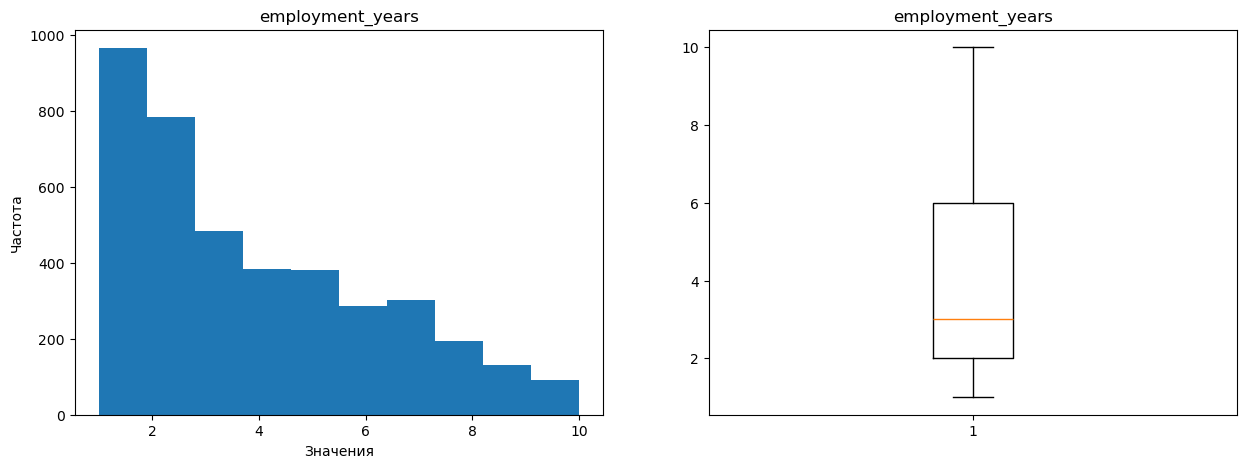

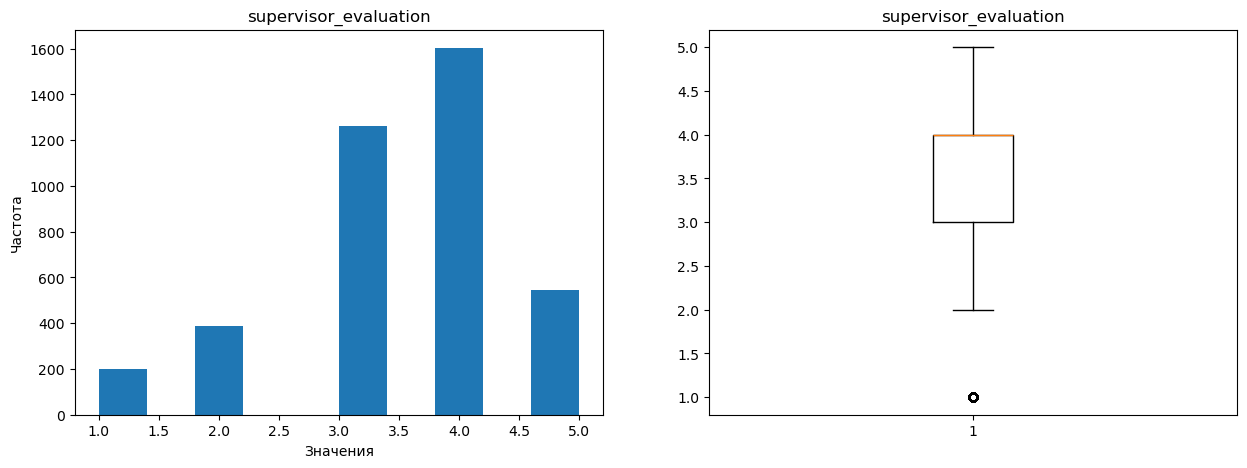

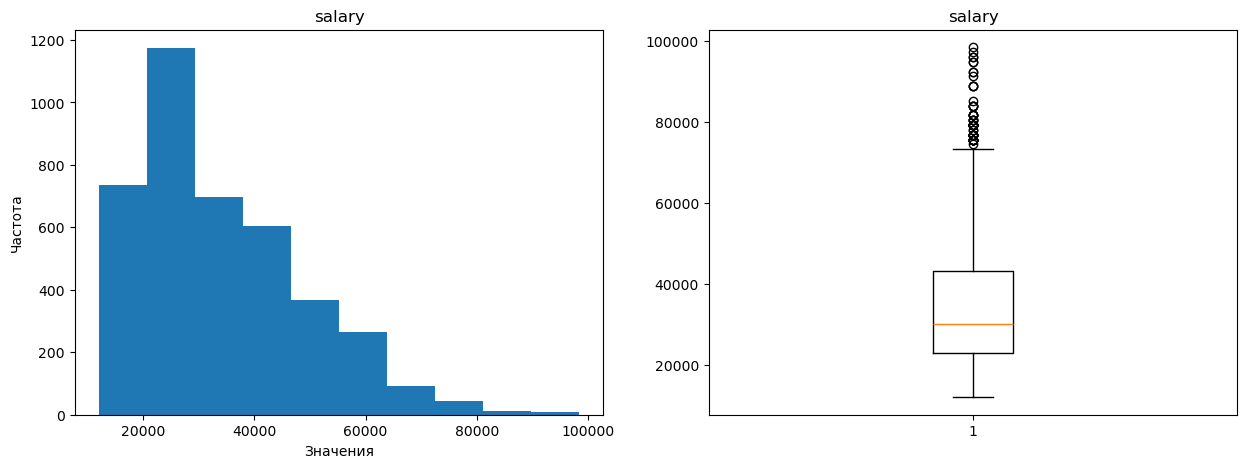

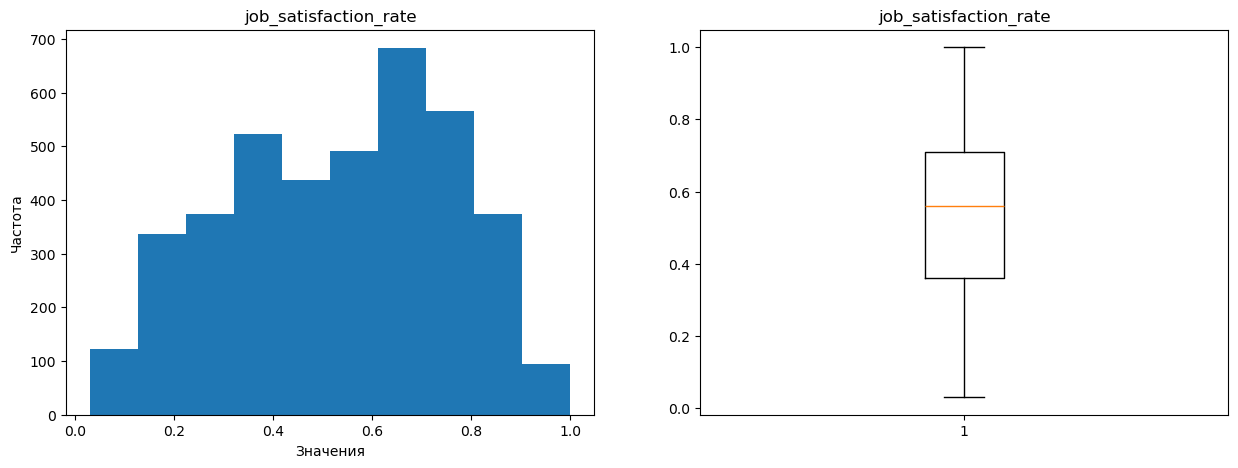

In [11]:
data_exam(train)

Видно, что:
- данные загрузились корректно;
- ращмерность датафрейма 10 столбцов и 4000 строк;
- типы данных корректны;
- в столбцах dept и level имеется незначительное количество пропусков;
- названия столбцов корректны;
- явные дубликаты отсутствуют;
- неявные дубликаты с одинаковым id отстутсвуют;
- в столбцах со строковыми типами данных нет неявных дубликатов, связанных с различным написанием одних и тех же слов;
- в числовых столбцах нет отрицательных значений;
- имеется выброс в столбце 'supervisor_evaluation', но это может быть вполне реальная оценка работодателя;
- имеются выбросы в столбце 'salary', но это тоже может быть вполне реальной картиной, так как зарплаты могут сильно отличаться друг от друга. 

##### Тестовая выборка входящих признаков

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB
**********************************************************************
Размерность таблицы:
 (2000, 9)
**********************************************************************


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


**********************************************************************
Количество пропусков:
 id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64
**********************************************************************
Названия столбцов:
 Index(['id', 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary'],
      dtype='object')
**********************************************************************
Количество явных дубликатов:
 0
**********************************************************************
Количество неявных дубликатов по столбцу "id":
 0
**********************************************************************
Уникальные значения в нечисловых столбцах
---------------------------------------------

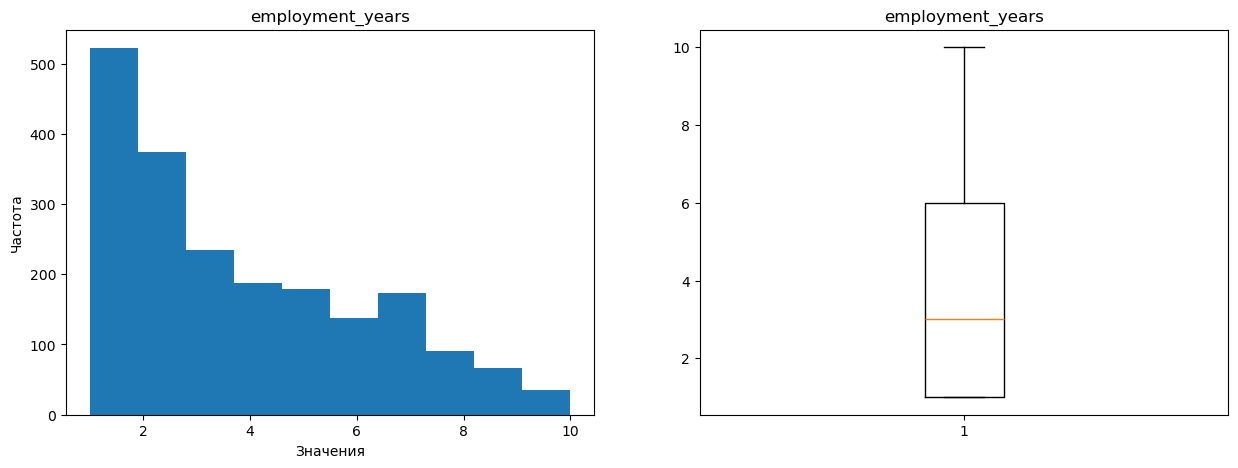

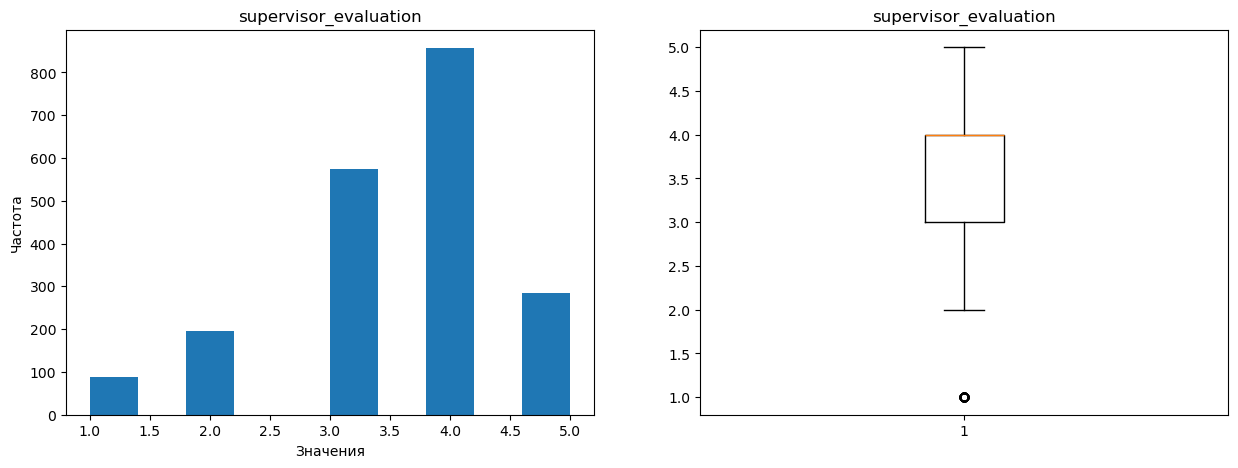

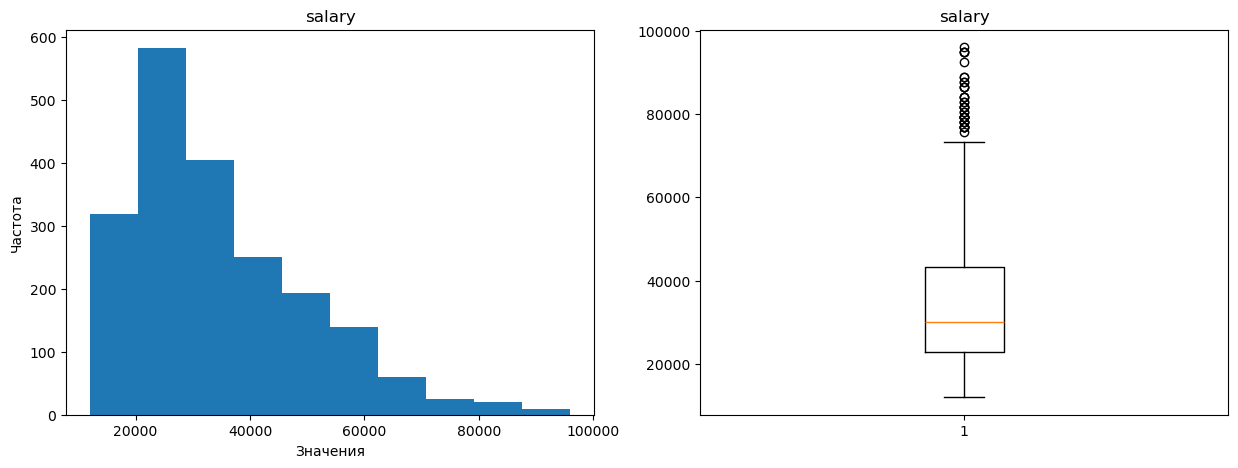

In [12]:
data_exam(X_test)

Видно, что:
- данные загрузились корректно;
- размерность датафрейма 9 столбцов и 2000 строк;
- типы данных корректны;
- в столбцах dept и level имеется незначительное количество пропусков;
- названия столбцов корректны;
- явные дубликаты отсутствуют;
- неявные дубликаты с одинаковым id отстутсвуют;
- в столбцах со строковыми типами данных нет неявных дубликатов, связанных с различным написанием одних и тех же слов;
- в столбцах dept и workload присутствуют пробелы в заполненных данных, что эквивалентно пропуску данных;
- в числовых столбцах нет отрицательных значений;
- имеется выброс в столбце 'supervisor_evaluation', но это может быть вполне реальная оценка работодателя;
- имеются выбросы в столбце 'salary', но это тоже может быть вполне реальной картиной, так как зарплаты могут сильно отличаться друг от друга. 

##### Тестовая выборка целевого признака

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB
**********************************************************************
Размерность таблицы:
 (2000, 2)
**********************************************************************


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


**********************************************************************
Количество пропусков:
 id                       0
job_satisfaction_rate    0
dtype: int64
**********************************************************************
Названия столбцов:
 Index(['id', 'job_satisfaction_rate'], dtype='object')
**********************************************************************
Количество явных дубликатов:
 0
**********************************************************************
Количество неявных дубликатов по столбцу "id":
 0
**********************************************************************
Уникальные значения в нечисловых столбцах
----------------------------------------------------------------------
**********************************************************************
Числовые столбцы


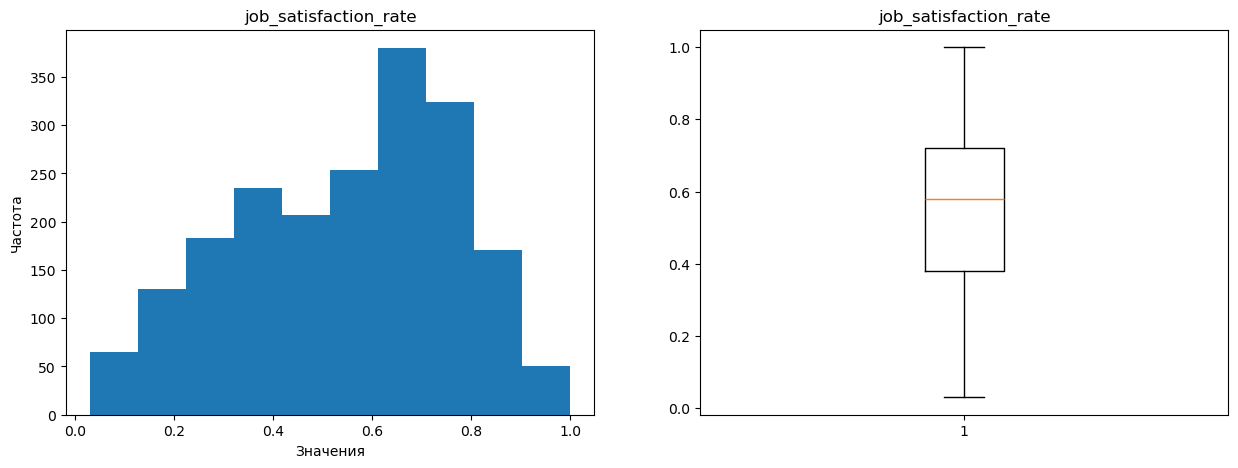

In [13]:
data_exam(y_test)

Видно, что:
- данные загрузились корректно;
- ращмерность датафрейма 2 столбца и 2000 строк;
- типы данных корректны;
- пропуски отстуствуют;
- названия столбцов корректны;
- явные дубликаты отсутствуют;
- неявные дубликаты с одинаковым id отстутсвуют;
- отрицательные значения отстуствуют.

#### Заполнение пропусков

##### Обработка пробелов

На этапе изучения данных, мы обнаружили, что кроме пропусков, присуствуют пробелы в датафрейме X_test, для столбцов 'dept' и 'workload'. Пробелы эквиваленты пропускам, поэтому для начала преобразуем пробелы в пропуски.

In [14]:
# применяем функцию преобразования, она сразу делает проверку
space_to_nan(X_test, ['dept', 'workload'])

Столбец dept
----------------------------------------------------------------------
До обработки:
Количество пробелов: 1
Количество NaN: 2
----------------------------------------------------------------------
После обработки:
Количество пробелов: 0
Количество NaN: 3
**********************************************************************
Столбец workload
----------------------------------------------------------------------
До обработки:
Количество пробелов: 1
Количество NaN: 0
----------------------------------------------------------------------
После обработки:
Количество пробелов: 0
Количество NaN: 1
**********************************************************************


##### Заполнение пропусков

В итоге, если рассматривать все датасеты - имеем пропуски в столбцах 'dept', 'workload' и 'level'. Вызовем пайплайн заполнения пропусков, качесте метода заполнения выберем заполнение наиболее часто встречающимся значением. Так как, после обратного преобразования в DataFrame, все типы данных становятся типом object, то сначала создадим список столбцов, для которых нужно будет вернуть тип данных int64. С типом float у нас только один столбец, с целевым показателем, его просто запомним.

In [15]:
# создаем список столбцов с целочисленными значениями
list_num_int = []
for column in train.columns:
    if train[column].dtype == 'int64':
        list_num_int.append(column)
list_num_int

['id', 'employment_years', 'supervisor_evaluation', 'salary']

In [16]:
# создаем пайплайн для заполнения пропусков
nan_columns = ['dept', 'level', 'workload']
replace_nan_pipe = Pipeline(
    [
        (
            'simpleImputer_replace_nan', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
        ),
    ]
)

In [17]:
# обучаем пайплан
replace_nan_pipe.fit(train)

# трансформируем пайплайном и получаем обратно объект DataFrame
train_ = pd.DataFrame(
    replace_nan_pipe.transform(train),
    columns=train.columns.to_list()
)

# возвращаем целочисленные типы данных
for column in list_num_int:
    train_[column] = train_[column].astype(int)
    
# возвращаем типы данных с плавающей точкой
train_['job_satisfaction_rate'] = train_['job_satisfaction_rate'].astype(float)

# результат
train_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int32  
 1   dept                   4000 non-null   object 
 2   level                  4000 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int32  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int32  
 8   salary                 4000 non-null   int32  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int32(4), object(5)
memory usage: 250.1+ KB


Пропуски заполнены.

Для заполнения пропусков в X_test тем же пайплайном, нужно чтобы количество столбцов совпадало с количеством столбцов, на котором обучали пайплайн, т.е. 10 столбцов. Поэтому предлагаю для этого этапа соединить тестовые выборки. Но для начала посмотрим насколько они идентичны по id пользователей.

In [18]:
X_test['id'].isin(y_test['id']).sum()

2000

Видим, что в обоих датафреймах одни и те же пользователи.

In [19]:
# щбъединяем по id
test_full=X_test.merge(y_test, on='id', how='left')

# смотрим что получилось
test_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   dept                   1997 non-null   object 
 2   level                  1999 non-null   object 
 3   workload               1999 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   int64  
 8   salary                 2000 non-null   int64  
 9   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 156.4+ KB


Объединение прошло успешно. Можно приступить к заполнению пропусков.

In [20]:
# трансформируем пайплайном и получаем обратно объект DataFrame
test_full = pd.DataFrame(
    replace_nan_pipe.transform(test_full),
    columns=test_full.columns.to_list(),
)

# возвращаем целочисленные типы данных
for column in list_num_int:
    test_full[column] = test_full[column].astype(int)
    
# возвращаем типы данных с плавающей точкой
test_full['job_satisfaction_rate'] = test_full['job_satisfaction_rate'].astype(float)

# результат
test_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int32  
 1   dept                   2000 non-null   object 
 2   level                  2000 non-null   object 
 3   workload               2000 non-null   object 
 4   employment_years       2000 non-null   int32  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   int32  
 8   salary                 2000 non-null   int32  
 9   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int32(4), object(5)
memory usage: 125.1+ KB


Пропуски заполнены. Вернем X_test.

In [21]:
X_test = test_full.drop(['job_satisfaction_rate'],axis=1)
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int32 
 1   dept                   2000 non-null   object
 2   level                  2000 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int32 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int32 
 8   salary                 2000 non-null   int32 
dtypes: int32(4), object(5)
memory usage: 109.5+ KB


### Исследовательский анализ

#### Исследование целевого признака

Сравним распределения целевого признака для обучающей и тестовой выборок.

In [22]:
# выделим целевой признак из обучающей выборки
у_train = pd.DataFrame(train_['job_satisfaction_rate'])
у_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1)
memory usage: 31.4 KB


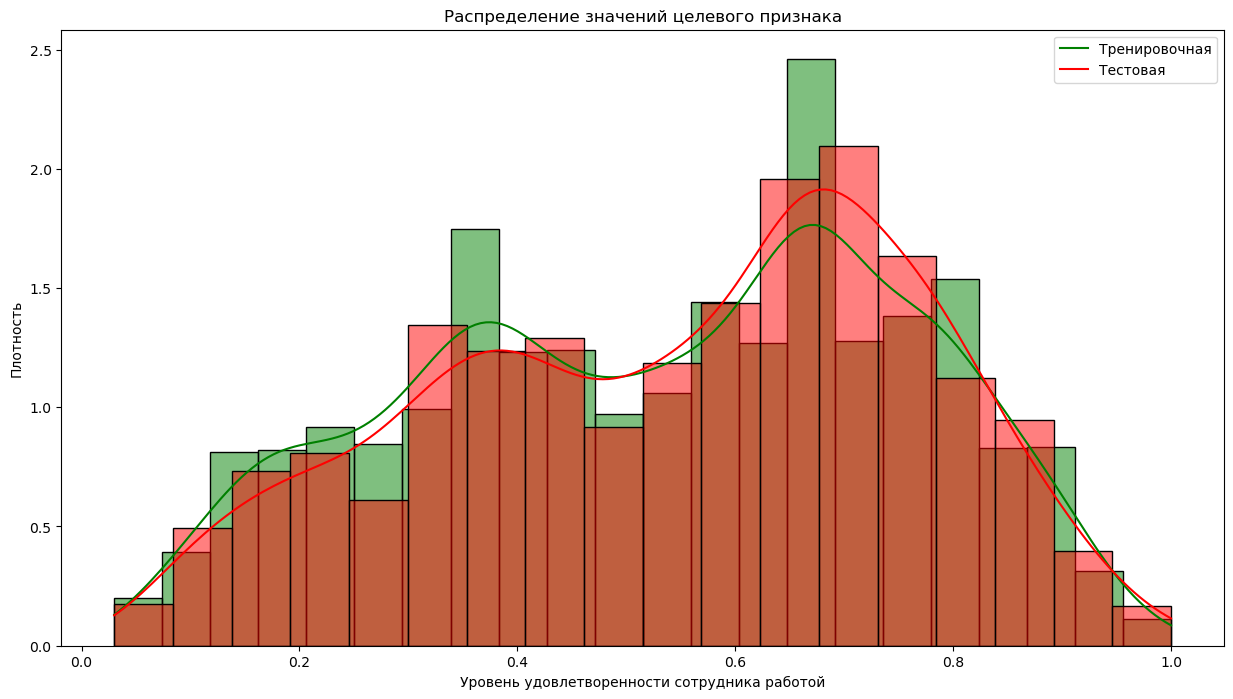

In [23]:
# вызовем функцию отрисовки двух наложенных диаграмм с нужными параметрами
u_x='job_satisfaction_rate'
u_labels= ['Тренировочная','Тестовая']
u_xlabel='Уровень удовлетворенности сотрудника работой'
u_title='Распределение значений целевого признака'

overlay_hist(у_train, y_test, u_x, u_labels, u_xlabel, u_title)

Можно сказать, что для обучающей и тестовой выборок, распределение целевого признака имеют схожий вид. В обоих случаях распределения отличны от нормального распределения. В целом распределения смещены вправо, имеются два пика разной интенсивности. 

#### Исследование количественных признаков

##### Дискретные признаки

**Сравним распределения признака 'employment_years' для обучающей и тестовой выборок.**

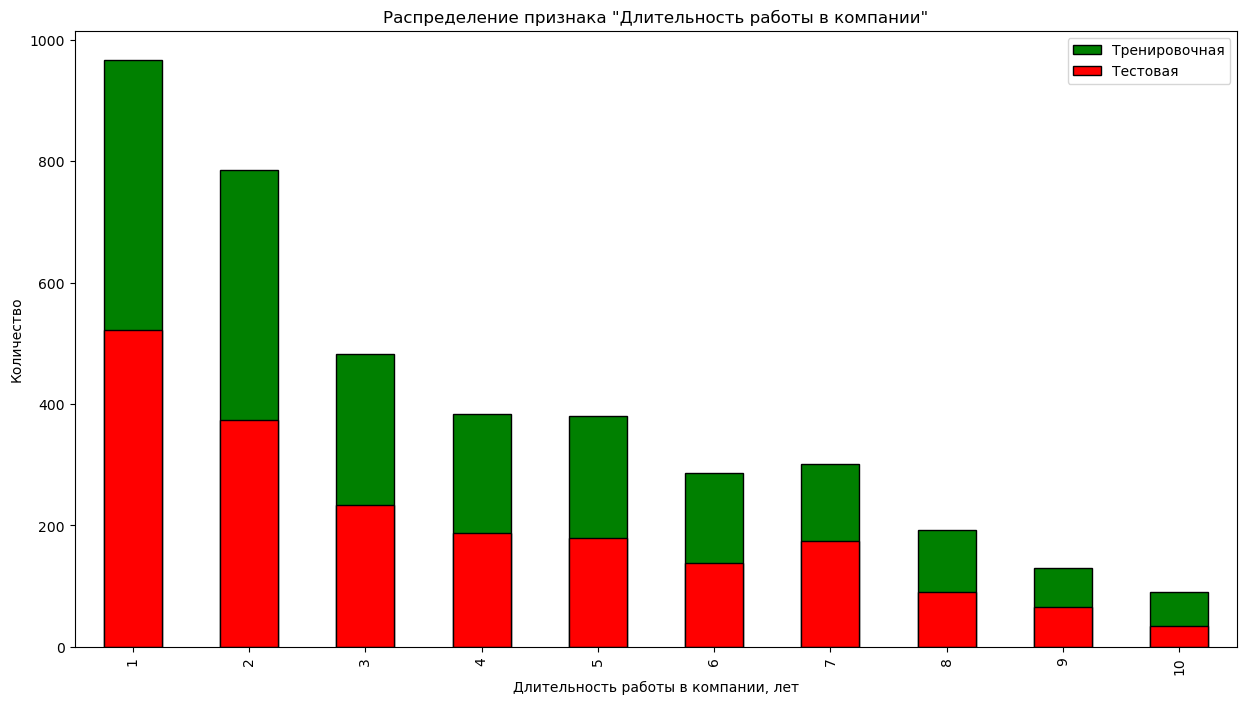

In [24]:
# вызовем функцию отрисовки двух наложенных барплотов с необходимыми параметрами
u_x='employment_years'
u_labels= ['Тренировочная','Тестовая']
u_xlabel='Длительность работы в компании, лет'
u_title='Распределение признака "Длительность работы в компании"'

bar_count(train_, X_test, u_x, u_labels, u_xlabel, u_title)

Можно сказать, что преобладаеи количество сотрудников, которые работают в компании 1-2 года. Далее видим понижающийся тренд. С увеличением длительности работы в компании, количество таких сотрудников снижается. И обучающая и тестовая выборки имеют схожее распределение.

**Сравним распределения признака 'supervisor_evaluation' для обучающей и тестовой выборок.**

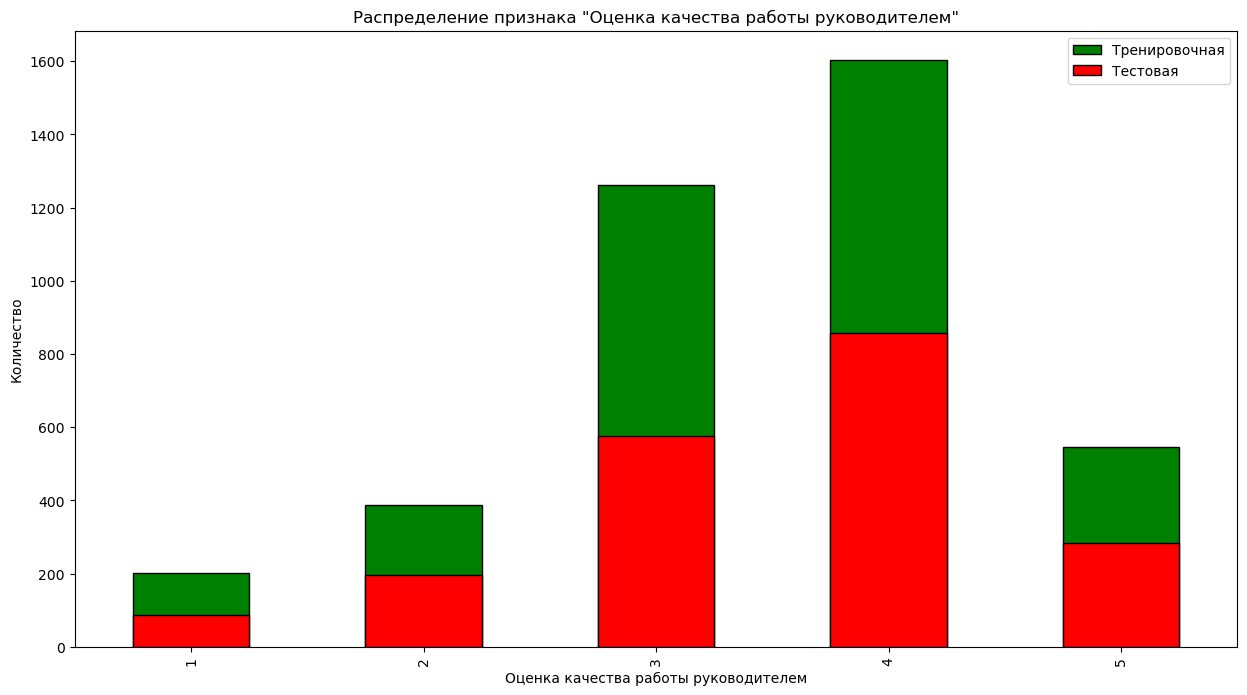

In [25]:
# вызовем функцию отрисовки двух наложенных барплотов с необходимыми параметрами
u_x='supervisor_evaluation'
u_labels= ['Тренировочная','Тестовая']
u_xlabel='Оценка качества работы руководителем'
u_title='Распределение признака "Оценка качества работы руководителем"'

bar_count(train_, X_test, u_x, u_labels, u_xlabel, u_title)

Можно сказать, что руководители чаще всего оценивают работу сотрудников на 3 и 4. И обучающая и тестовая выборки имеют схожее распределение.

##### Непрерывный признак

**Сравним распределения признака 'salary' для обучающей и тестовой выборок.**

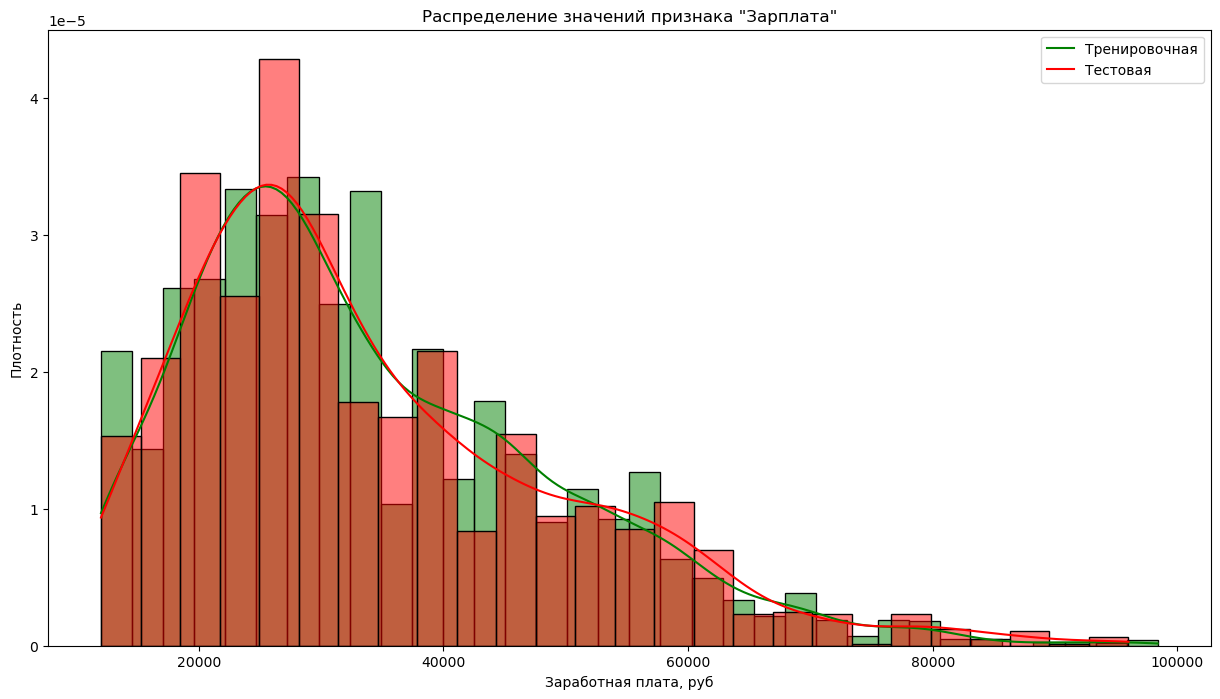

In [26]:
# вызовем функцию отрисовки двух наложенных диаграмм с нужными параметрами
u_x='salary'
u_labels= ['Тренировочная','Тестовая']
u_xlabel='Заработная плата, руб'
u_title='Распределение значений признака "Зарплата"'

overlay_hist(train_, X_test, u_x, u_labels, u_xlabel, u_title)

Можно сказать, что для обучающей и тестовой выборок, распределения  имеют схожий вид. В обоих случаях распределения отличны от нормального распределения. В целом распределения смещены влево. Пик распределения отмечается для значения зарплаты в 30 000, далее идет плавное снижение.

#### Исследование качественных признаков

**Сравним распределения признака 'dept' для обучающей и тестовой выборок.**

                                        Соотношение кол-ва сотрудников по отделам


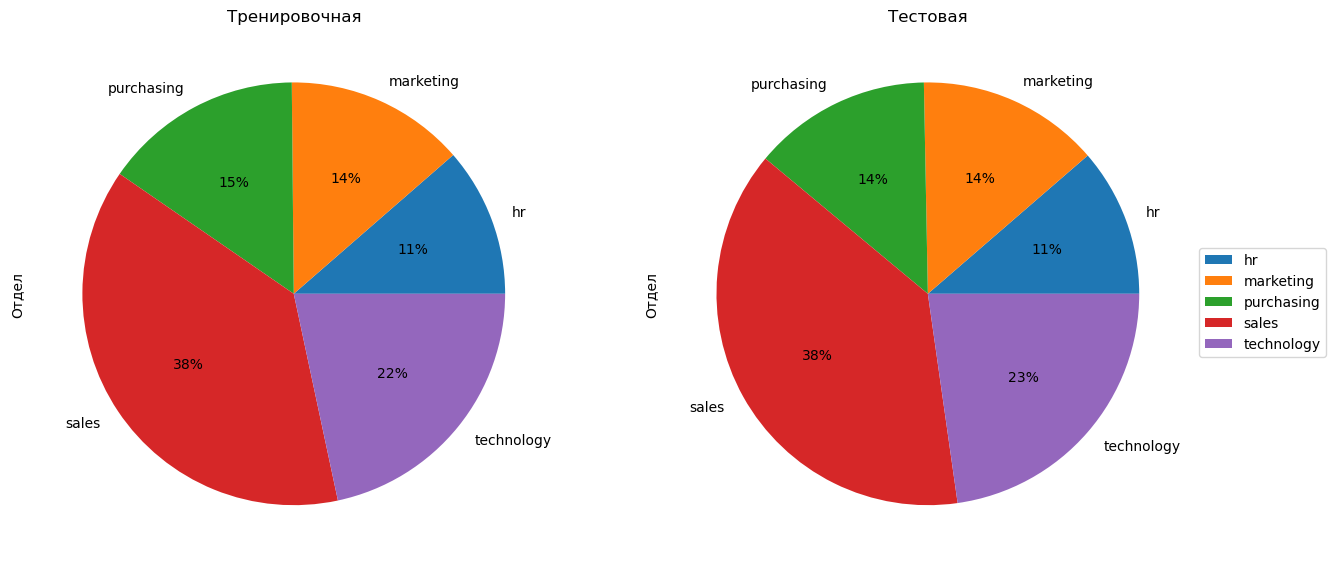

In [27]:
# вызовем функцию отрисовки двух пайплотов
u_title = 'Соотношение кол-ва сотрудников по отделам'
u_ylabel = 'Отдел'
column = ['dept']

pie_two_samples(train_, X_test, u_title, u_ylabel, column)

Можно сказать, что для обучающей и тестовой выборок, распределения  имеют схожий вид. Больше всего сотрудников работает в отделе продаж, меньше всего в hr.

**Сравним распределения признака 'level' для обучающей и тестовой выборок.**

                                        Соотношение кол-ва сотрудников по уровням должности


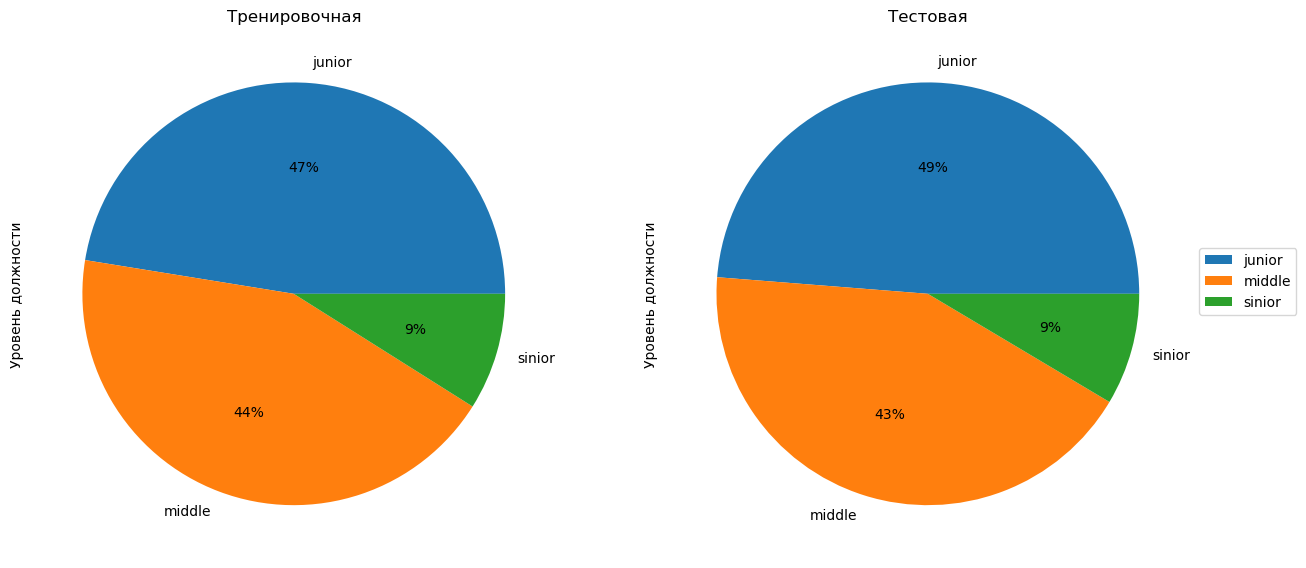

In [28]:
# вызовем функцию отрисовки двух пайплотов
u_title = 'Соотношение кол-ва сотрудников по уровням должности'
u_ylabel = 'Уровень должности'
column = ['level']

pie_two_samples(train_, X_test, u_title, u_ylabel, column)

Можно сказать, что для обучающей и тестовой выборок, распределения  имеют схожий вид. Больше всего сотрудников имеют уровень junior и middle.

**Сравним распределения признака 'workload' для обучающей и тестовой выборок.**

                                        Соотношение кол-ва сотрудников по загруженности


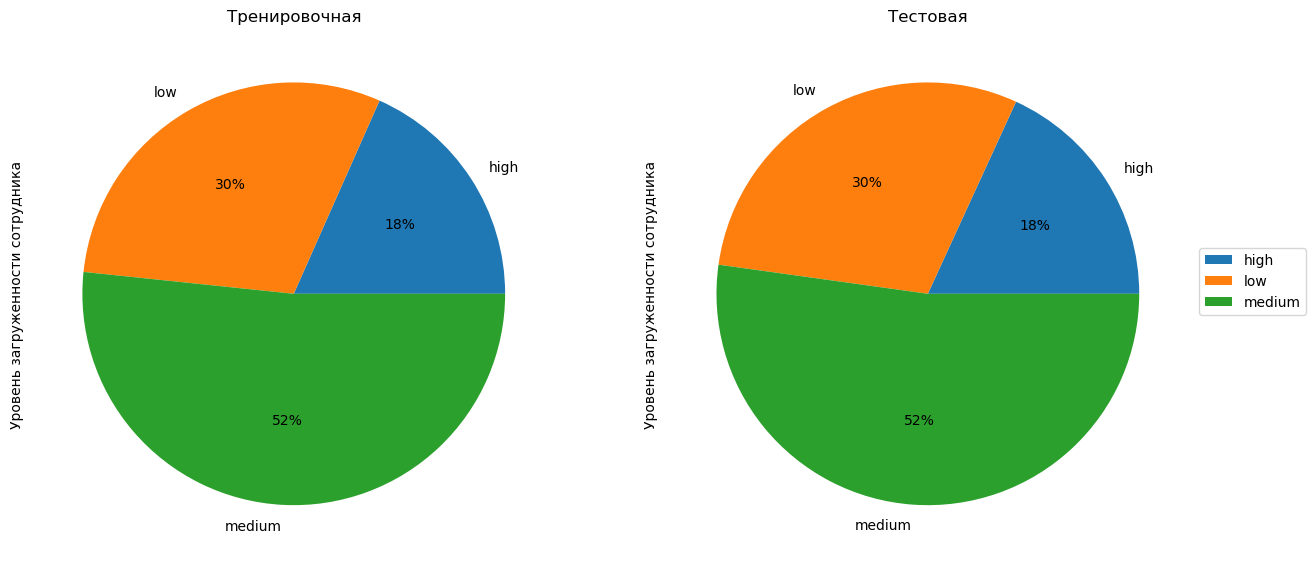

In [29]:
# вызовем функцию отрисовки двух пайплотов
u_title = 'Соотношение кол-ва сотрудников по загруженности'
u_ylabel = 'Уровень загруженности сотрудника'
column = ['workload']

pie_two_samples(train_, X_test, u_title, u_ylabel, column)

Можно сказать, что для обучающей и тестовой выборок, распределения  имеют схожий вид. Больше всего сотрудников оценивают свою трудовую нагрузку как среднюю.

**Сравним распределения признака 'last_year_promo' для обучающей и тестовой выборок.**

                                        Соотношение кол-ва сотрудников по повышениям


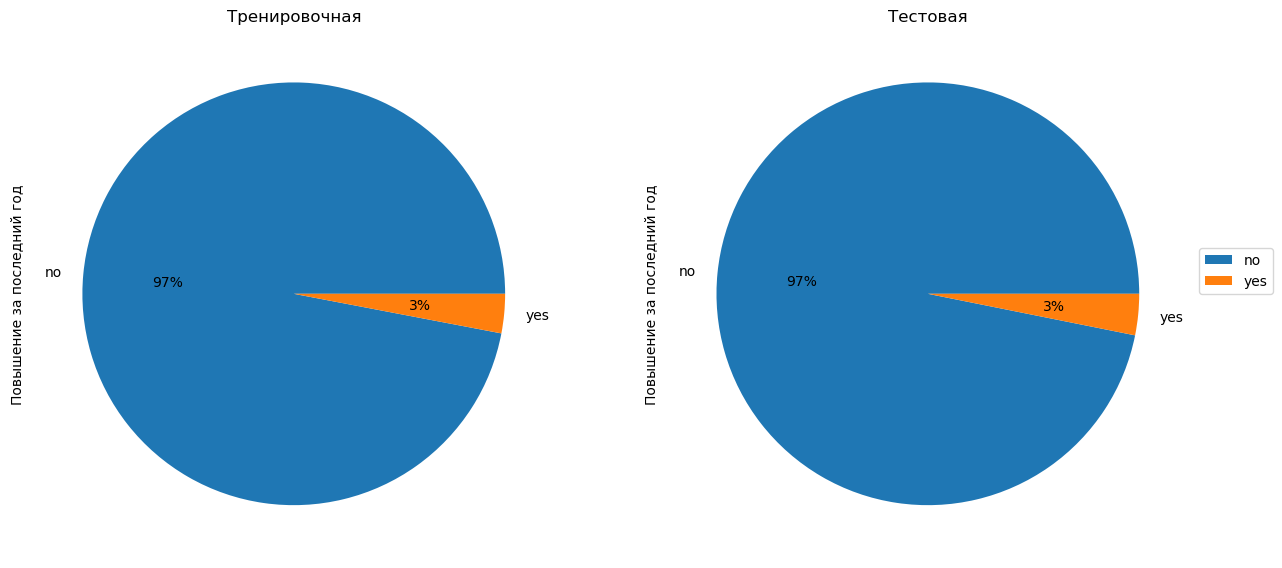

In [30]:
# вызовем функцию отрисовки двух пайплотов
u_title = 'Соотношение кол-ва сотрудников по повышениям'
u_ylabel = 'Повышение за последний год'
column = ['last_year_promo']

pie_two_samples(train_, X_test, u_title, u_ylabel, column)

Можно сказать, что для обучающей и тестовой выборок, распределения  имеют схожий вид. Повышение за последний год получили 3% сотрудников.

**Сравним распределения признака 'last_year_violations' для обучающей и тестовой выборок.**

                                        Соотношение кол-ва сотрудников по нарушениям


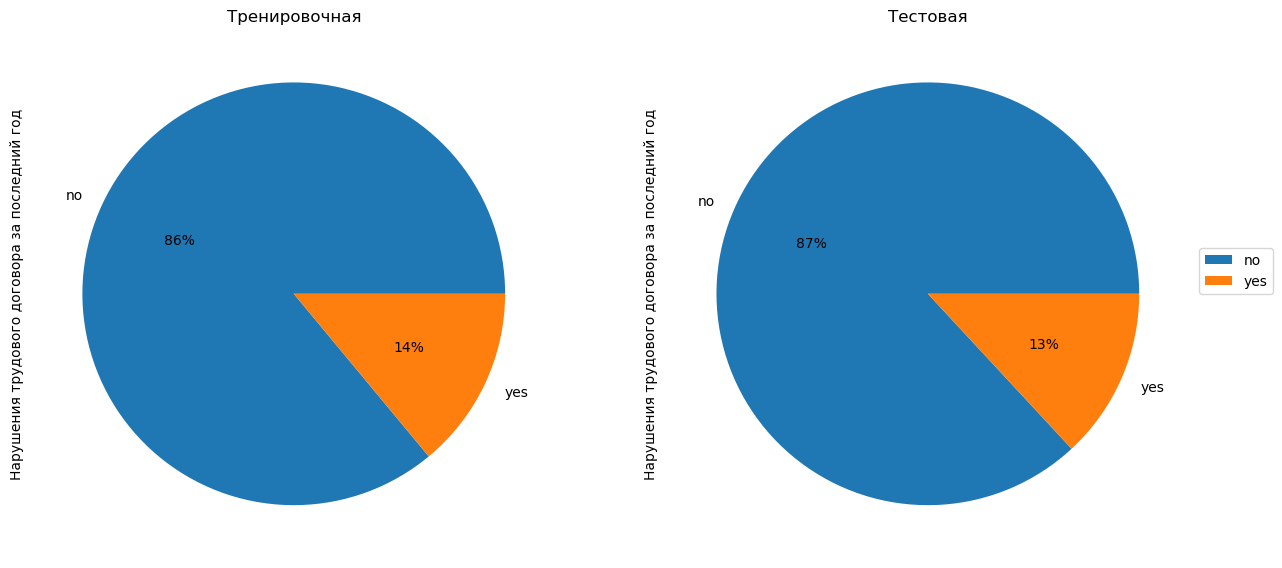

In [31]:
# вызовем функцию отрисовки двух пайплотов
u_title = 'Соотношение кол-ва сотрудников по нарушениям'
u_ylabel = 'Нарушения трудового договора за последний год'
column = ['last_year_violations']

pie_two_samples(train_, X_test, u_title, u_ylabel, column)

Можно сказать, что для обучающей и тестовой выборок, распределения  имеют схожий вид. Менее 15% сотрудников нарушали трудовой догвор за последний год.

Можно сделать следующие выводы:
- все признаки имеют схожие распределения для тренировочной и тестовых выборок;
- преобладает количество сотрудников, которые работают в компании 1-2 года;
- руководители чаще всего оценивают работу сотрудников на 3 и 4;
- самая частая зарплата 30 000;
- больше всего сотрудников имеют уровень junior и middle;
- больше всего сотрудников оценивают свою трудовую нагрузку как среднюю;
- повышение за последний год получили 3% сотрудников;
- менее 15% сотрудников нарушали трудовой догвор за последний год;
----------------------------------------------------------------------------------------
- целевой признак 'job_satisfaction_rate': непрерывный количесетвенный признак, распределение не имеет нормальный вид, смещено вправо;
-------------------------------------------------------------------------------------------
- признак 'salary': непрерывный количесетвенный признак, распределение не имеет нормальный вид, смещено влево;
- признак 'employment_years': дискретный количественный признак;
- признак 'supervisor_evaluation': дискретный количественный признак;
- маштабы этих признаков отличаются 3-4 порядка, при подготовке данных потребуется масштабирование;
-------------------------------------------------------------------------------------------
- признаки 'last_year_promo' и 'last_year_violations': бинарные категориальные признаки, потребуется  кодирование с помощью OneHotEncoder;
- признаки 'dept', 'level' и 'workload': небинарные категориальные признаки, потребуется кодирование с помощью OrdinalEncoder

#### Кореляционный анализ

Исследуем датафреймы на предмет утечки цеоевого признака.

                                        Тренировочная выборка


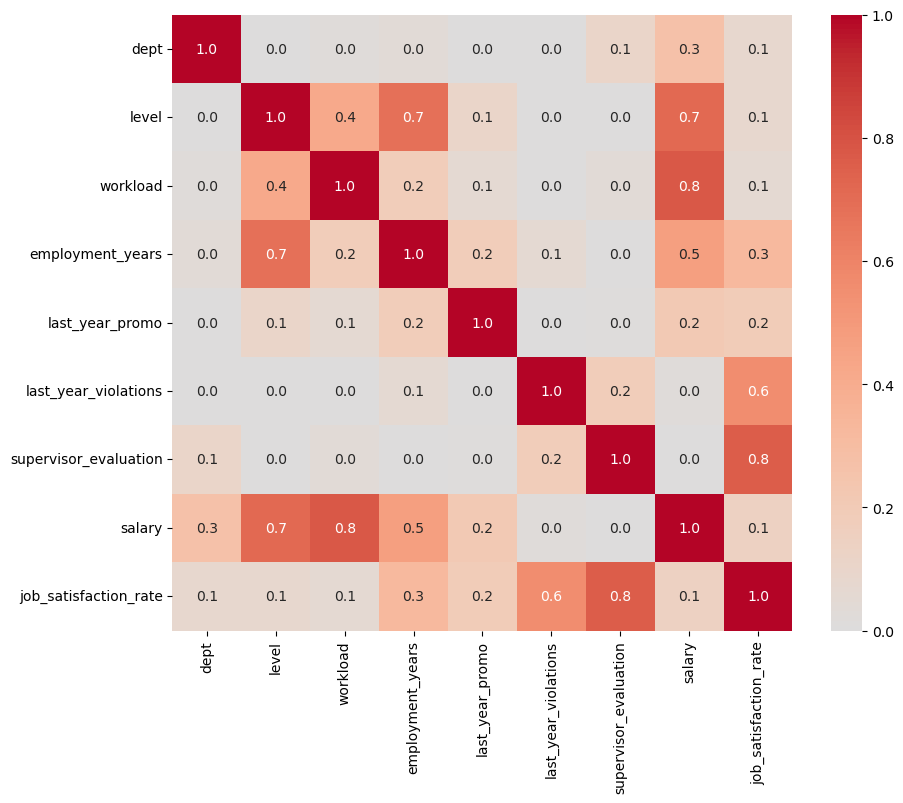

In [32]:
# уберем стобец id, так как он не несет смысла для корреляционного анализа
# применим функцию отрисовки корреляционных матриц, с необходимыми параметрами
train_corr = train_.drop(['id'], axis=1)
u_interval_cols = ['salary', 'job_satisfaction_rate']

print(' '*40 + 'Тренировочная выборка')
corr_heatmap(train_corr, u_interval_cols)

                                        Тестовая выборка


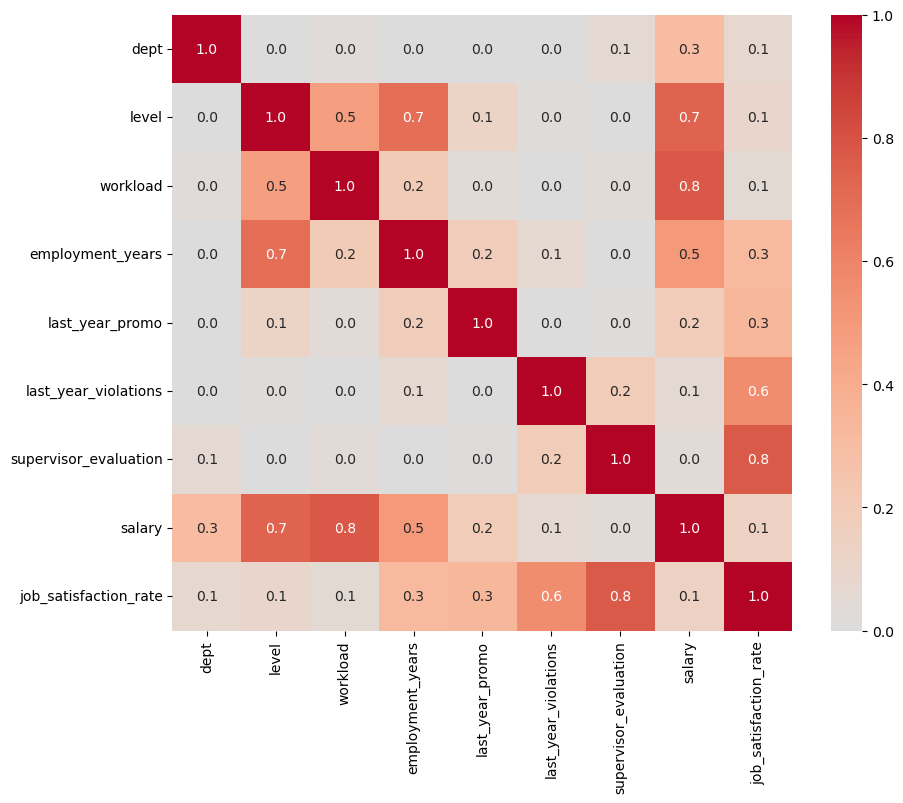

In [33]:
# уберем стобец id, так как он не несет смысла для корреляционного анализа
# применим функцию отрисовки корреляционных матриц, с необходимыми параметрами
test_corr = test_full.drop(['id'], axis=1)
u_interval_cols = ['salary', 'job_satisfaction_rate']
print(' '*40 + 'Тестовая выборка')
corr_heatmap(test_corr, u_interval_cols)

Можно сказать, что для тренировочной и тестовой выборок, корреляционные матрицы имеют схожий вид. Утечки целевого признака не обнаружено. Для всех, рассматриваемых признаков отрицательной корреляции не обнаружено. Целевой признак лучше всего коррелирует с оценкой руководителя и наличием фактов нарушения трудового договора. Можно отметить хорошую корреляцию между зарплатой и уровнем должности сотрудника, рабочей нагрузкой, трудовым стажем в компании.

In [34]:
X_test_old = X_test.copy()
y_test_old = y_test.copy()

### Подготовка данных

Основываясь на результатах, проведенного осмотра данных и результатах исследовательского анализа, проведем предобработку данных, по следующему плану:
- удалим признак id в выборках, как не несущий информации для моделирования. в тренировочной выборке, после удаления нужно будет проверить выборку на дубликаты, в случае их наличия - удалить;
- разделить  выборки на входящие и целевой признаки;
- Количественные признаки: employment_years, supervisor_evaluation и salary. Необходимо будет масштабировать;
- Качественные признаки: last_year_promo и last_year_violations. Кодируем OneHotEncoder;
- Качественные признаки: dept, level и workload. Кодируем OrdinalEncoder.

#### Удаление признака id, проверка дубликатов

In [35]:
# удаляем id в треноировочной выборке
train_temp = train_.drop(['id'], axis=1)

# проверяем дубликаты
train_temp.duplicated().sum()

248

In [36]:
# удаляем дубликаты
train_temp = train_temp.drop_duplicates().reset_index(drop=True)

# проверяем
train_temp.shape

(3752, 9)

In [37]:
# удаляем id в тестовой выборке
test_full = test_full.drop(['id'], axis=1)

test_full.shape

(2000, 9)

#### Разделение выборок на входящие и целевые признаки

In [38]:
# разделяем тренировочную выборку
X_train = train_temp.drop(['job_satisfaction_rate'], axis=1)
y_train = train_temp['job_satisfaction_rate']

# проверим
X_train.shape, y_train.shape

((3752, 8), (3752,))

In [39]:
# разделяем тестовую выборку
X_test = test_full.drop(['job_satisfaction_rate'], axis=1)
y_test = test_full['job_satisfaction_rate']

# проверим
X_test.shape, y_test.shape

((2000, 8), (2000,))

#### Создание пайплайна предобработки

Хотя на предыдущем шаге мы начинали создавать пайплайн для заполенения пропусков и уже заполнили их, предлагаю с этого шага создать новый более универсальный пайплайн, в котором так же будет шаг заполнения пропусков. 

In [40]:
# зададим константу генерации пвсевдослучайных величин 
RANDOM_STATE = 12345

# определим метрику качества при помощи функции подсчета SMAPE
scorer = make_scorer(SMAPE, greater_is_better=False)

In [41]:
# определим списки по типам параметров
ohe_columns = ['last_year_promo', 'last_year_violations']
ord_columns = ['dept', 'level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

In [42]:
# создаем пайплайн для ohe

ohe_pipe = Pipeline(
    [('simpleImputer_ohe_nan', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('simpleImputer_ohe_', SimpleImputer(missing_values=' ', strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='error'))
    ]
)

In [43]:
# создаем пайплайн для ord

ord_pipe = Pipeline(
    [('simpleImputer_before_ord_nan', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('simpleImputer_before_ord_', SimpleImputer(missing_values=' ', strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['sales', 'hr', 'technology', 'purchasing', 'marketing'],
                    ['junior', 'middle', 'sinior'],
                    ['low','medium', 'high']
                ],
                handle_unknown= 'use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [44]:
# создаём общий пайплайн для подготовки данных

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [45]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
]
)

### Обучение моделей

Целевой признак у нас количественный, непрерывный. Тогда для обучения будем использовать модели регресии: линейная регрессия и дерево решений.

In [46]:
# зададим ниперпараметры для оценщика
param_grid = [
    # словарь для модели DecisionTreeRegressor()
    {
     'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
     'models__max_depth': range(2, 40),
     'models__max_features': range(2, 7),
     'models__min_samples_split': range(2, 10),
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
]

In [47]:
# инициализируем оценщик и подберем лучшую модель
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring=scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    error_score='raise'
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', -1*randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe_nan',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('simpleImputer_ohe_',
                                                                   SimpleImputer(missing_values=' ',
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['last_year_promo',
                                                   'last_year_violations'])

На тренирововочной выборке получили SMAPE = 15,95. Для лучшей модели. Проверим на тестовой.

In [48]:
# проверяем лучшую модель на тестовой выборке 
job_satisfaction_rate_pred = randomized_search.predict(X_test)
print(f'Метрика на тестовой выборке: {SMAPE(y_test, job_satisfaction_rate_pred)}')

Метрика на тестовой выборке: 14.21698634905448


In [49]:
# проверяем модель на адекватность на константной модели
lm_dummy_mean = DummyRegressor(strategy = 'mean').fit(X_train, y_train)
y_predict_dummy_mean = lm_dummy_mean.predict(X_test) 
print(f'Метрика на константной модели: {SMAPE(y_test, y_predict_dummy_mean)}')

Метрика на константной модели: 38.262831018170885


Модель адекватна.

In [50]:
# выведем результаты других моделей
res = pd.DataFrame(randomized_search.cv_results_)
res.mean_test_score = res.mean_test_score * -1
res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__min_samples_split,param_models__max_features,param_models__max_depth,param_models,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.050203,0.001408,0.012080,0.000704,passthrough,3,5,31,"DecisionTreeRegressor(max_depth=30, max_featur...","{'preprocessor__num': 'passthrough', 'models__...",-16.222004,-15.518496,-16.586826,-16.369333,-15.747815,16.088895,0.396482,2
1,0.042912,0.001390,0.011046,0.001059,passthrough,7,2,20,"DecisionTreeRegressor(max_depth=30, max_featur...","{'preprocessor__num': 'passthrough', 'models__...",-19.038493,-16.040501,-18.183325,-17.243400,-17.420184,17.585181,0.999996,6
2,0.043271,0.011388,0.011040,0.000898,StandardScaler(),6,2,31,"DecisionTreeRegressor(max_depth=30, max_featur...","{'preprocessor__num': StandardScaler(), 'model...",-17.612561,-15.983127,-17.801918,-18.530658,-18.506838,17.687020,0.927990,8
3,0.036654,0.001467,0.010875,0.001389,passthrough,7,2,31,"DecisionTreeRegressor(max_depth=30, max_featur...","{'preprocessor__num': 'passthrough', 'models__...",-19.038493,-17.606801,-18.183325,-18.240885,-17.420184,18.097937,0.567967,9
4,0.036263,0.002231,0.010153,0.002411,passthrough,6,2,36,"DecisionTreeRegressor(max_depth=30, max_featur...","{'preprocessor__num': 'passthrough', 'models__...",-17.408666,-16.129722,-17.730368,-18.574859,-18.518801,17.672483,0.892592,7
5,0.036076,0.002938,0.012611,0.001498,passthrough,6,3,39,"DecisionTreeRegressor(max_depth=30, max_featur...","{'preprocessor__num': 'passthrough', 'models__...",-17.508477,-15.931128,-18.567211,-17.602564,-16.674768,17.256830,0.894007,5
6,0.043173,0.002029,0.018335,0.012861,StandardScaler(),9,4,30,"DecisionTreeRegressor(max_depth=30, max_featur...","{'preprocessor__num': StandardScaler(), 'model...",-16.524116,-15.960623,-18.344815,-17.547743,-17.022983,17.080056,0.822655,3
7,0.038738,0.002480,0.012812,0.001074,StandardScaler(),8,4,6,"DecisionTreeRegressor(max_depth=30, max_featur...","{'preprocessor__num': StandardScaler(), 'model...",-21.272234,-19.869727,-21.585263,-22.148955,-20.285596,21.032355,0.838975,10
8,0.042110,0.002653,0.011373,0.000492,MinMaxScaler(),9,4,28,"DecisionTreeRegressor(max_depth=30, max_featur...","{'preprocessor__num': MinMaxScaler(), 'models_...",-16.524116,-15.899402,-18.454454,-17.558341,-16.971054,17.081473,0.875513,4
9,0.037701,0.004167,0.007890,0.000723,StandardScaler(),5,5,30,"DecisionTreeRegressor(max_depth=30, max_featur...","{'preprocessor__num': StandardScaler(), 'model...",-16.102242,-14.845945,-16.743495,-16.275986,-15.783408,15.950215,0.633367,1


Таким образом видим, что лучшая модель DecisionTreeRegressor(max_depth=30, max_features=5, min_samples_split=5). Метрика SMAPE на тестовой выборке получилась 14.216. Модель линейной регресии в данном случае не подходит из-за отстутствия линейной корреляции между признаками и преобладанием качественныз признаков над количественными.

### Вывод по задаче 1

По результатм проделанной работы можно сделать следующие выводы:
_________________________________________________________________________
- все данные загрузились корректно;
- размерность тренировочного датафрейма: 10 стобцов / 4000 строк; размерность тестового датафрейма входящих признаков: 9 стобцов / 2000 строк; размерность тестового датафрейма целевого признака: 2 стобца / 2000 строк.
- во всех датафреймах: типы данных корректны, отстуствуют явные и неявные дубликаты, названия столбцов корректны, отстутсвуют отрицательные значения в числовых столбцах;
- наблюдается небольшое количество пропусков в качественных признаках, их доля менее 0.5% от всего объема данных, для конткретного датафрейма;
- в некоторых числовых столбцах присутствую логичные выбросы: зарплата и оценка руководителя;
__________________________________________________________________________
- пропуски в данных были заполнены наиболее часто встречающимися значениями;
- все признаки имеют схожие распределения для тренировочного и тестовых выборок;
- распределения целевого признака и величины зарплаты отличны от нормального;
___________________________________________________________________________
- преобладает количество сотрудников, которые работают в компании 1-2 года;
- руководители чаще всего оценивают работу сотрудников на 3 и 4;
- самая частая зарплата 30 000;
- больше всего сотрудников имеют уровень junior и middle;
- больше всего сотрудников оценивают свою трудовую нагрузку как среднюю;
- повышение за последний год получили 3% сотрудников;
- менее 15% сотрудников нарушали трудовой догвор за последний год;
- целевой признак лучше всего коррелирует с оценкой руководителя и наличием фактов нарушения трудового договора. Можно отметить хорошую корреляцию между зарплатой и уровнем должности сотрудника, рабочей нагрузкой, трудовым стажем в компании;
______________________________________________________________________________
- для предсказания параметра удовлетворенности сотрудника наилучший результат показала модель: DecisionTreeRegressor(max_depth=30, max_features=5, min_samples_split=5)
- Метрика SMAPE на тестовой выборке получилась 14.216.

## Задача 2. Предсказание увольнения сотрудника из компании.

### Загрузка данных

In [51]:
try:
    train_1 = pd.read_csv('/datasets/train_quit.csv')
    y_test_1 = pd.read_csv('/datasets/test_target_quit.csv')
except:
    train_1 = pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv')
    y_test_1 = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv')

In [52]:
# так как тестовый набор входящих признаков у нас не изменился, относительно предыдущей задачи,
# то присвоим ему значение из предыдущей задачи, причем пропуски уже будут заполнены
X_test_1 = X_test_old

### Предобработка данных

#### Изучение данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB
**********************************************************************
Размерность таблицы:
 (4000, 10)
**********************************************************************


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


**********************************************************************
Количество пропусков:
 id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64
**********************************************************************
Названия столбцов:
 Index(['id', 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary', 'quit'],
      dtype='object')
**********************************************************************
Количество явных дубликатов:
 0
**********************************************************************
Количество неявных дубликатов по столбцу "id":
 0
**********************************************************************
Уникальные значения в нечисловых столбцах
----------

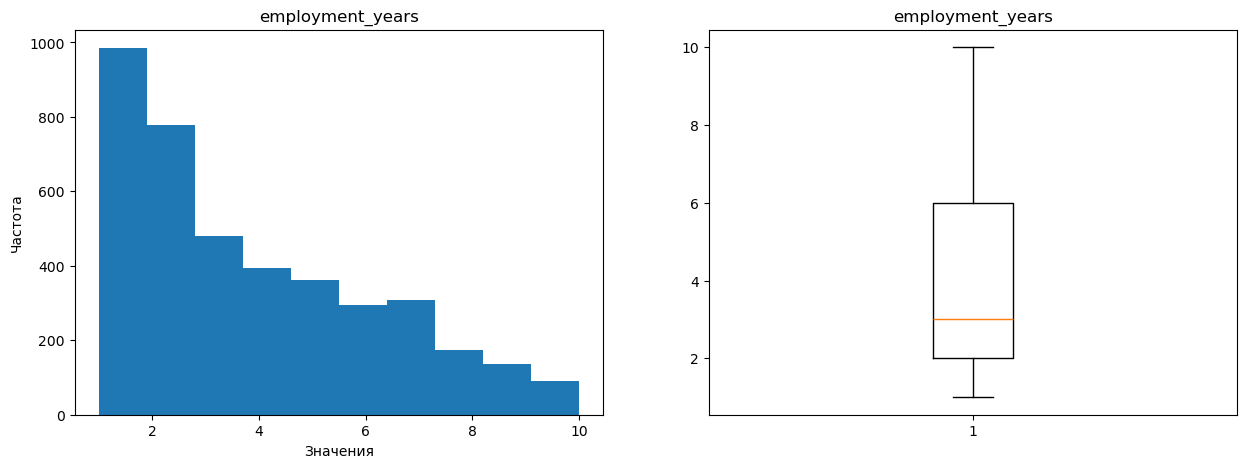

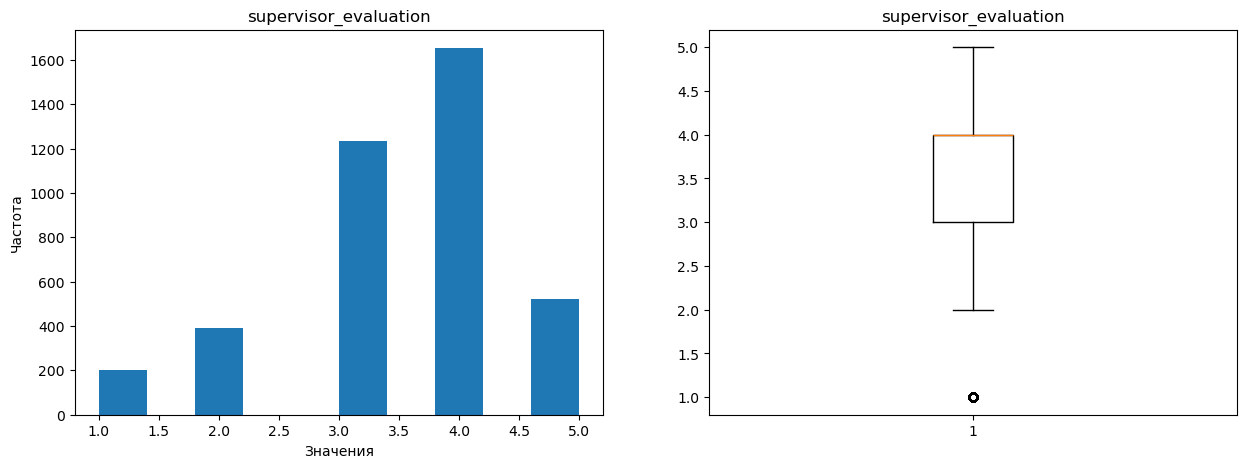

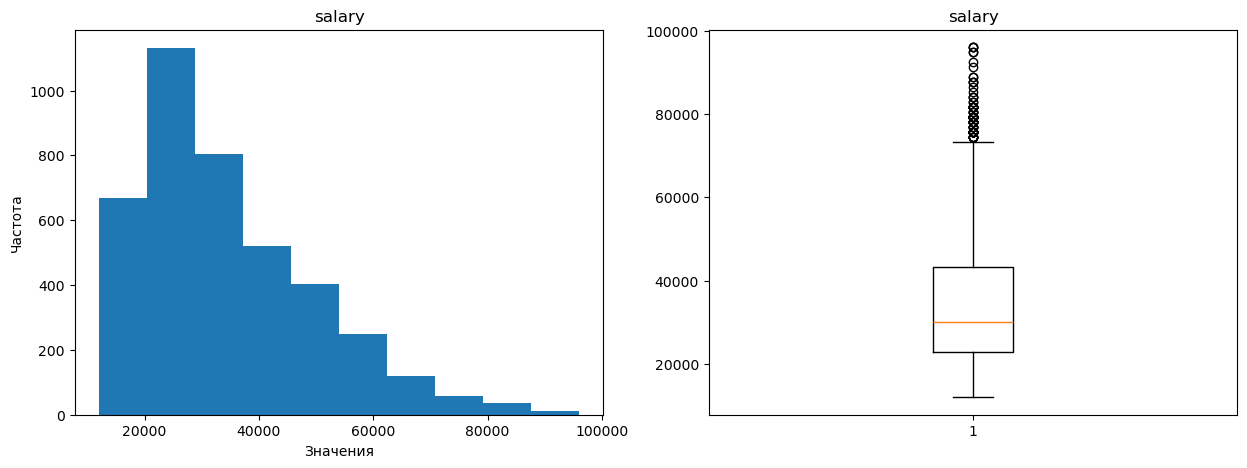

In [53]:
data_exam(train_1)

- данные загрузились корректно;
- ращмерность датафрейма 10 столбцов и 4000 строк;
- типы данных корректны;
- пропуски отстуствуют;
- названия столбцов корректны;
- явные дубликаты отсутствуют;
- неявные дубликаты с одинаковым id отстутсвуют;
- в столбцах со строковыми типами данных нет неявных дубликатов, связанных с различным написанием одних и тех же слов;
- в числовых столбцах нет отрицательных значений;
- имеется выброс в столбце 'supervisor_evaluation', но это может быть вполне реальная оценка работодателя;
- имеются выбросы в столбце 'salary', но это тоже может быть вполне реальной картиной, так как зарплаты могут сильно отличаться друг от друга.


In [54]:
data_exam(y_test_1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB
**********************************************************************
Размерность таблицы:
 (2000, 2)
**********************************************************************


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


**********************************************************************
Количество пропусков:
 id      0
quit    0
dtype: int64
**********************************************************************
Названия столбцов:
 Index(['id', 'quit'], dtype='object')
**********************************************************************
Количество явных дубликатов:
 0
**********************************************************************
Количество неявных дубликатов по столбцу "id":
 0
**********************************************************************
Уникальные значения в нечисловых столбцах
----------------------------------------------------------------------
Столбец quit : ['yes' 'no']
**********************************************************************
Числовые столбцы


- данные загрузились корректно;
- ращмерность датафрейма 2 столбца и 2000 строк;
- типы данных корректны;
- пропуски отстуствуют;
- названия столбцов корректны;
- явные дубликаты отсутствуют;
- неявные дубликаты с одинаковым id отстутсвуют;

### Исследовательский анализ

#### Общий исследовательский анализ

##### Предварительное сравнение

Для начала выясним, свопадает ли текущая тренировочная выборка с прошлой. Если они одинаковы, то можно будет не проводить детальное исследование признаков. Если нет, то необходимо будет провести.

In [55]:
train.isin(train_1).sum()

id                          0
dept                      978
level                    1707
workload                 1589
employment_years          541
last_year_promo          3777
last_year_violations     3056
supervisor_evaluation    1153
salary                    115
job_satisfaction_rate       0
dtype: int64

Видим, что тренировочные наборы разные, анализ признаков понадобится.

Сразу проверим одинаковые ли id для тестовых выборок в этой задаче.

In [56]:
X_test_1['id'].isin(y_test_1['id']).sum()

2000

Все нормально, описываются одни и те же персоналии.

##### Исследование целевого признака

                                        Соотношение кол-ва сотрудников по увольнениям


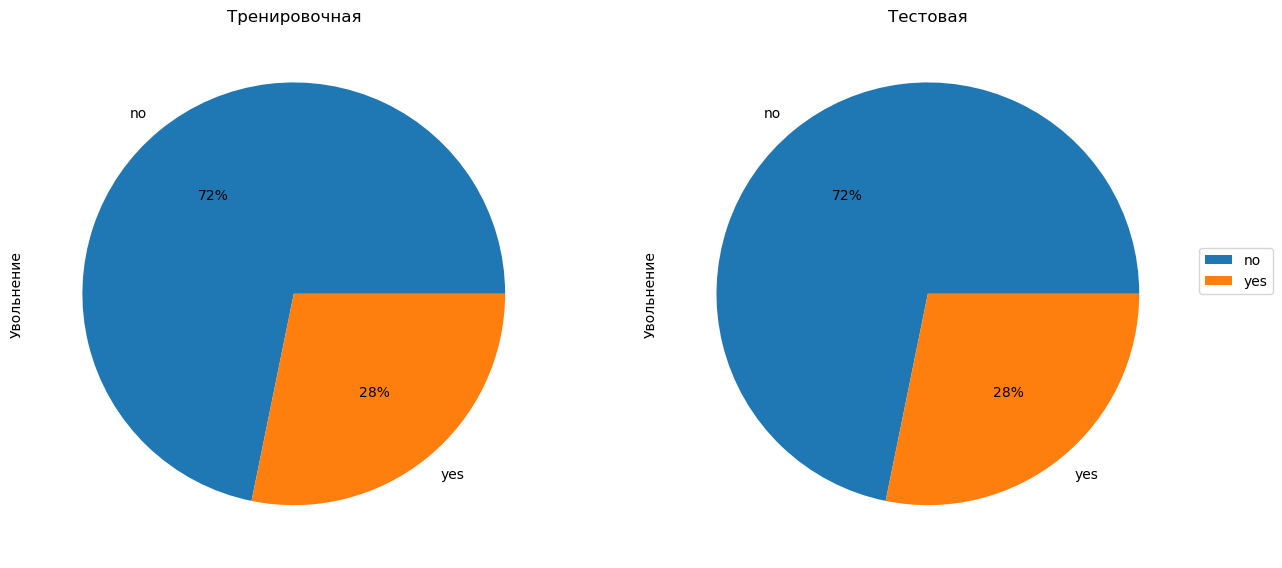

In [57]:
# вызовем функцию отрисовки двух пайплотов
u_title = 'Соотношение кол-ва сотрудников по увольнениям'
u_ylabel = 'Увольнение'
column = ['quit']

pie_two_samples(train_1, y_test_1, u_title, u_ylabel, column)

Можно сказать, что оба распределения имеют одинаковый вид. За отчетный период уволилось 28% сотрудников.

##### Исследование количественных признаков

###### Дискретные признаки

**Сравним распределения признака 'employment_years' для обучающей и тестовой выборок.**

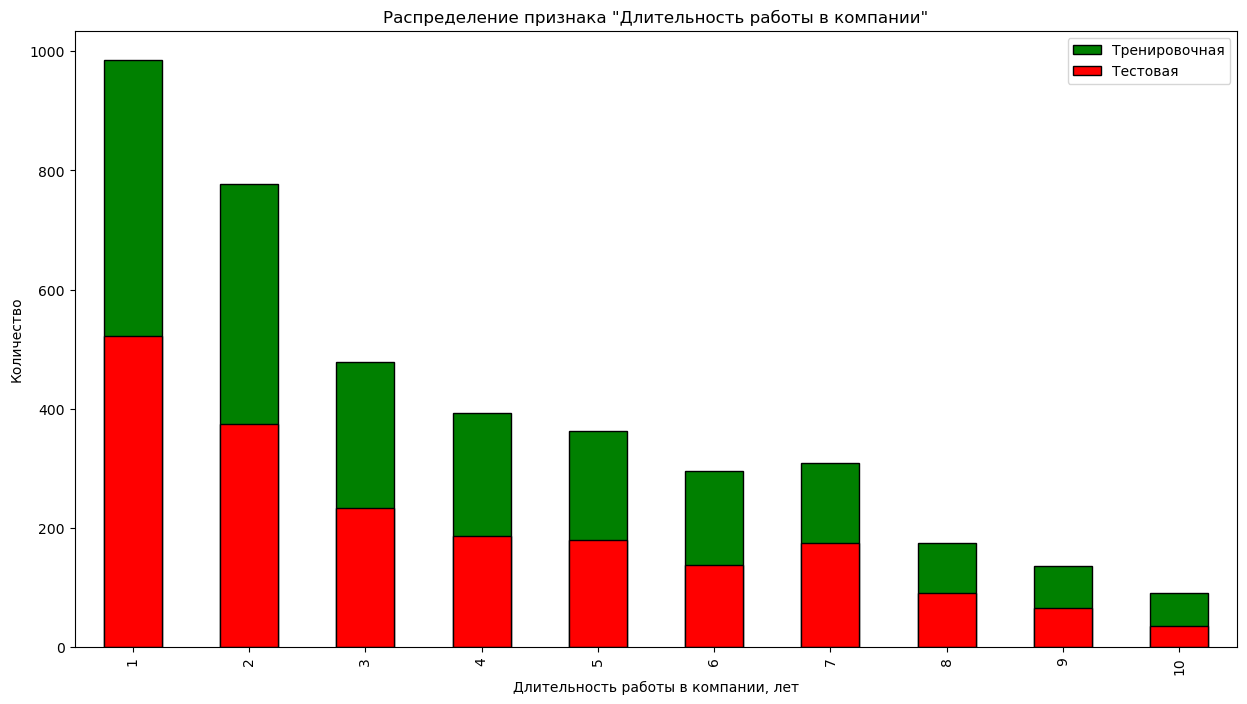

In [58]:
# вызовем функцию отрисовки двух наложенных барплотов с необходимыми параметрами
u_x='employment_years'
u_labels= ['Тренировочная','Тестовая']
u_xlabel='Длительность работы в компании, лет'
u_title='Распределение признака "Длительность работы в компании"'

bar_count(train_1, X_test_1, u_x, u_labels, u_xlabel, u_title)

Можно сказать, что преобладаеи количество сотрудников, которые работают в компании 1-2 года. Далее видим понижающийся тренд. С увеличением длительности работы в компании, количество таких сотрудников снижается. И обучающая и тестовая выборки имеют схожее распределение.

**Сравним распределения признака 'supervisor_evaluation' для обучающей и тестовой выборок.**

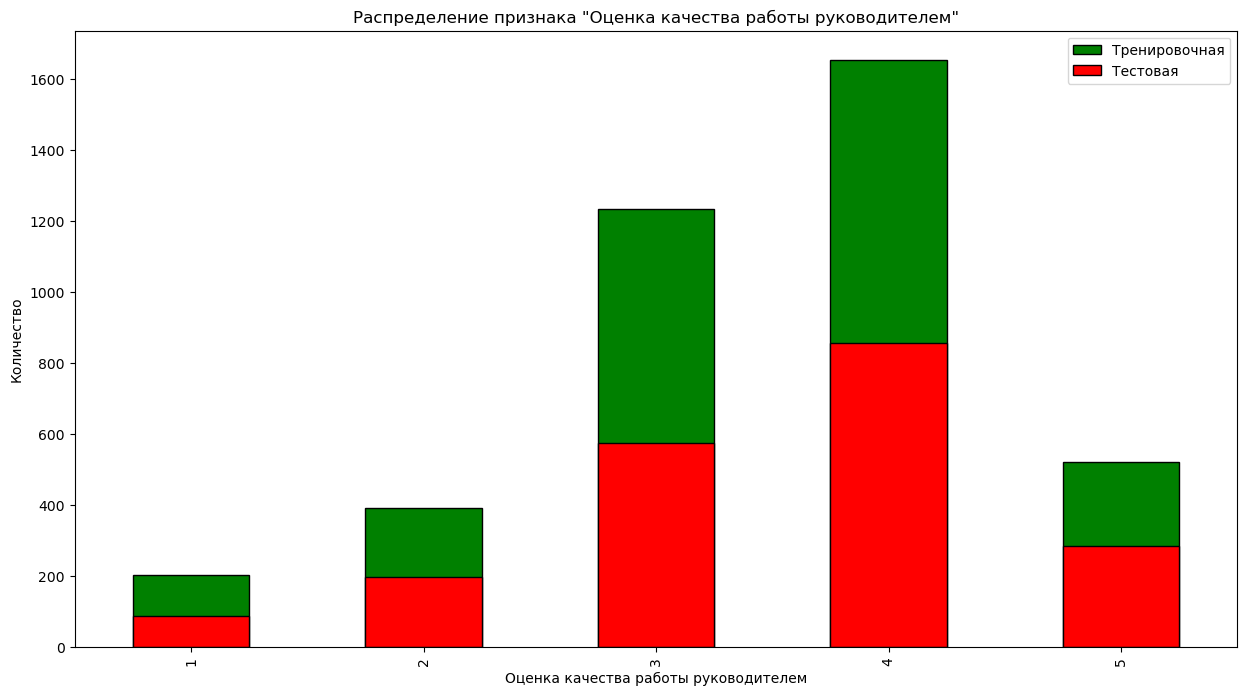

In [59]:
# вызовем функцию отрисовки двух наложенных барплотов с необходимыми параметрами
u_x='supervisor_evaluation'
u_labels= ['Тренировочная','Тестовая']
u_xlabel='Оценка качества работы руководителем'
u_title='Распределение признака "Оценка качества работы руководителем"'

bar_count(train_1, X_test_1, u_x, u_labels, u_xlabel, u_title)

Можно сказать, что руководители чаще всего оценивают работу сотрудников на 3 и 4. И обучающая и тестовая выборки имеют схожее распределение.

###### Непрерывный признак

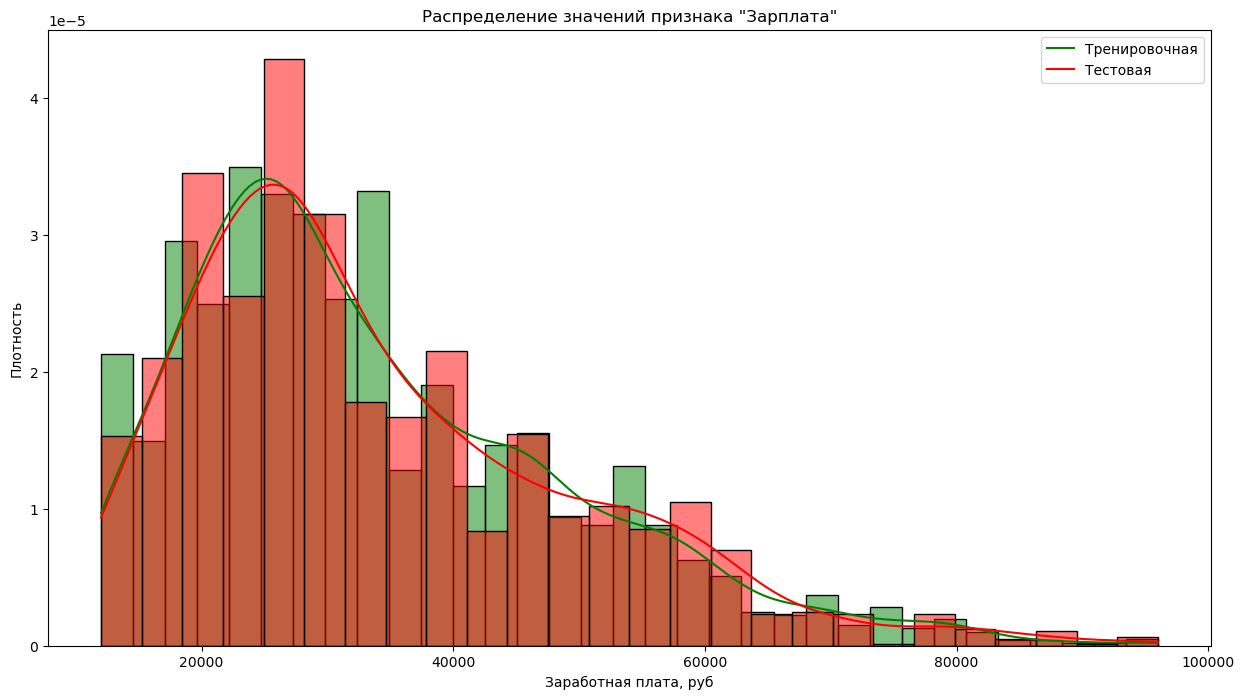

In [60]:
# вызовем функцию отрисовки двух наложенных диаграмм с нужными параметрами
u_x='salary'
u_labels= ['Тренировочная','Тестовая']
u_xlabel='Заработная плата, руб'
u_title='Распределение значений признака "Зарплата"'

overlay_hist(train_1, X_test_1, u_x, u_labels, u_xlabel, u_title)

Можно сказать, что для обучающей и тестовой выборок, распределения  имеют схожий вид. В обоих случаях распределения отличны от нормального распределения. В целом распределения смещены влево. Пик распределения отмечается для значения зарплаты в 30 000, далее идет плавное снижение.

##### Исследование качественных признаков

**Сравним распределения признака 'dept' для обучающей и тестовой выборок.**

                                        Соотношение кол-ва сотрудников по отделам


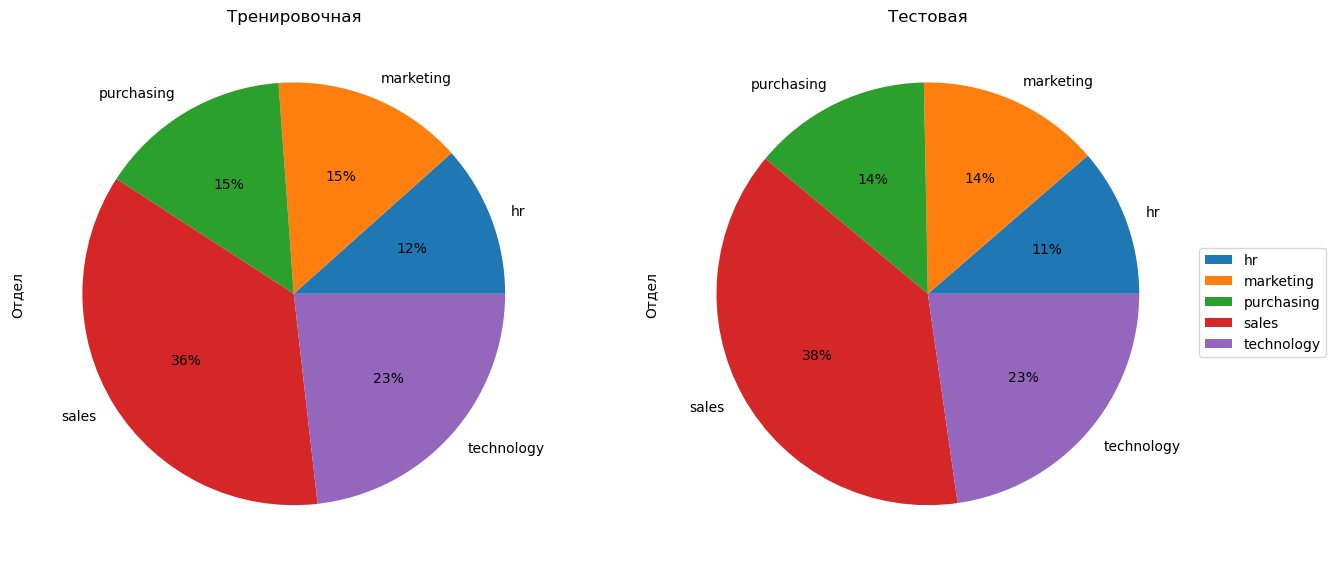

In [61]:
# вызовем функцию отрисовки двух пайплотов
u_title = 'Соотношение кол-ва сотрудников по отделам'
u_ylabel = 'Отдел'
column = ['dept']

pie_two_samples(train_1, X_test_1, u_title, u_ylabel, column)

Можно сказать, что для обучающей и тестовой выборок, распределения  имеют схожий вид. Больше всего сотрудников работает в отделе продаж, меньше всего в hr.

**Сравним распределения признака 'level' для обучающей и тестовой выборок.**

                                        Соотношение кол-ва сотрудников по уровням должности


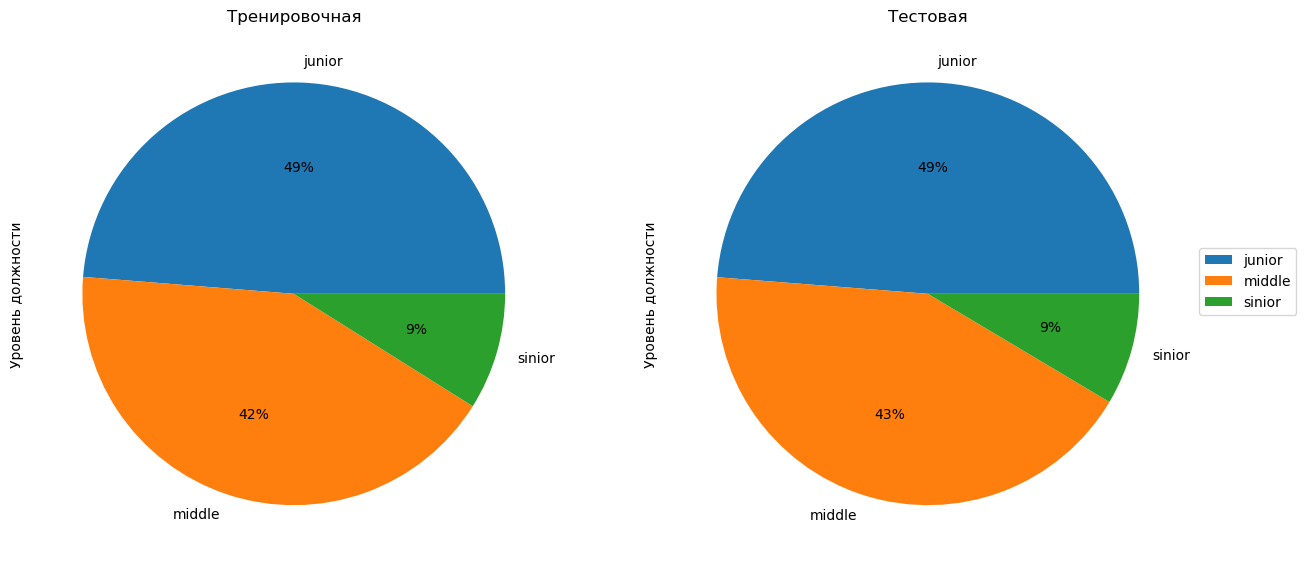

In [62]:
# вызовем функцию отрисовки двух пайплотов
u_title = 'Соотношение кол-ва сотрудников по уровням должности'
u_ylabel = 'Уровень должности'
column = ['level']

pie_two_samples(train_1, X_test_1, u_title, u_ylabel, column)

Можно сказать, что для обучающей и тестовой выборок, распределения  имеют схожий вид. Больше всего сотрудников имеют уровень junior и middle.

**Сравним распределения признака 'workload' для обучающей и тестовой выборок.**

                                        Соотношение кол-ва сотрудников по загруженности


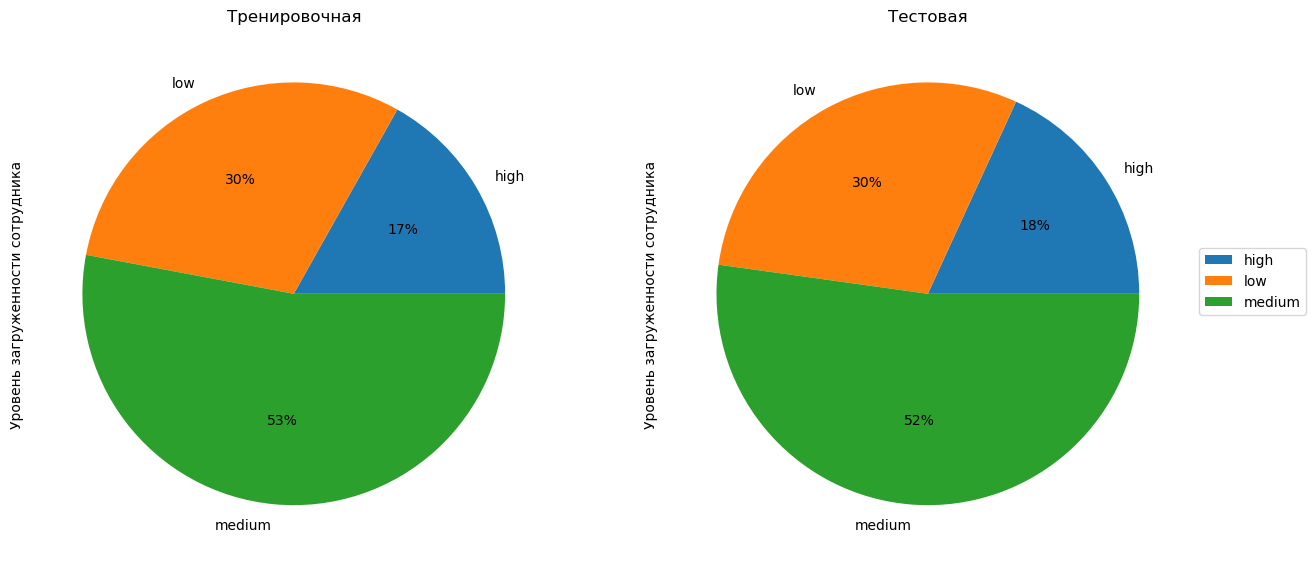

In [63]:
# вызовем функцию отрисовки двух пайплотов
u_title = 'Соотношение кол-ва сотрудников по загруженности'
u_ylabel = 'Уровень загруженности сотрудника'
column = ['workload']

pie_two_samples(train_1, X_test_1, u_title, u_ylabel, column)

Можно сказать, что для обучающей и тестовой выборок, распределения  имеют схожий вид. Больше всего сотрудников оценивают свою трудовую нагрузку как среднюю.

**Сравним распределения признака 'last_year_promo' для обучающей и тестовой выборок.**

                                        Соотношение кол-ва сотрудников по повышениям


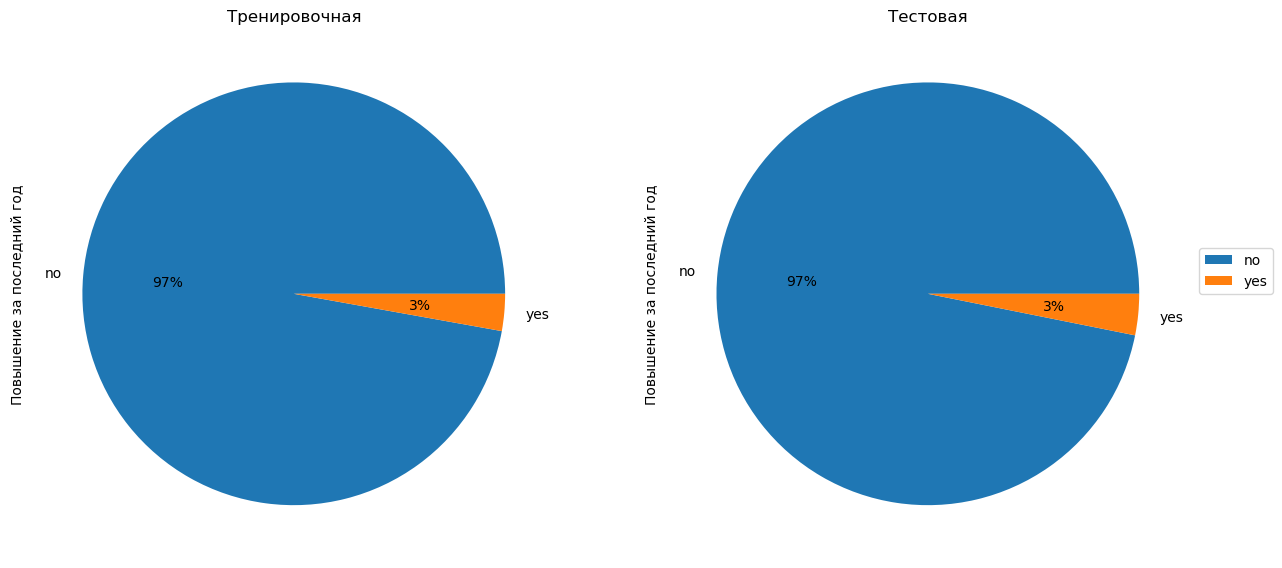

In [64]:
# вызовем функцию отрисовки двух пайплотов
u_title = 'Соотношение кол-ва сотрудников по повышениям'
u_ylabel = 'Повышение за последний год'
column = ['last_year_promo']

pie_two_samples(train_1, X_test_1, u_title, u_ylabel, column)

Можно сказать, что для обучающей и тестовой выборок, распределения  имеют схожий вид. Повышение за последний год получили 3% сотрудников.

**Сравним распределения признака 'last_year_violations' для обучающей и тестовой выборок.**

                                        Соотношение кол-ва сотрудников по нарушениям


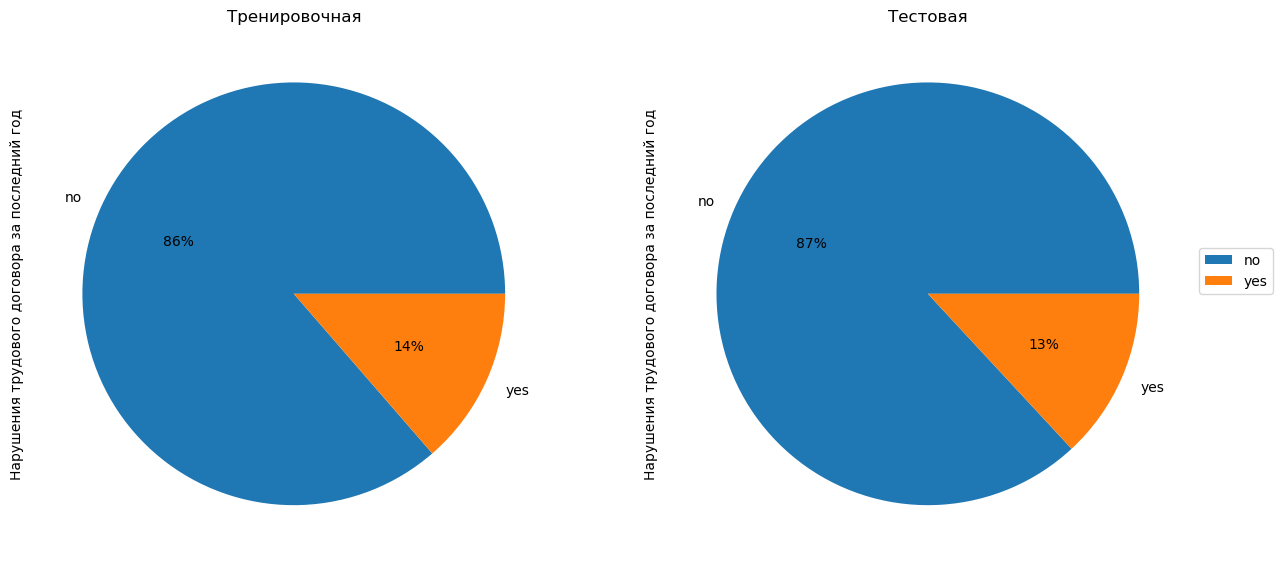

In [65]:
# вызовем функцию отрисовки двух пайплотов
u_title = 'Соотношение кол-ва сотрудников по нарушениям'
u_ylabel = 'Нарушения трудового договора за последний год'
column = ['last_year_violations']

pie_two_samples(train_1, X_test_1, u_title, u_ylabel, column)

Можно сказать, что для обучающей и тестовой выборок, распределения  имеют схожий вид. Менее 15% сотрудников нарушали трудовой догвор за последний год.

Можно сделать следующие выводы:
- все признаки имеют схожие распределения для тренировочной и тестовых выборок;
- доля всех уволившихся сотрудников составляет 28 %;
- преобладает количество сотрудников, которые работают в компании 1-2 года;
- руководители чаще всего оценивают работу сотрудников на 3 и 4;
- самая частая зарплата 30 000;
- больше всего сотрудников имеют уровень junior и middle;
- больше всего сотрудников оценивают свою трудовую нагрузку как среднюю;
- повышение за последний год получили 3% сотрудников;
- менее 15% сотрудников нарушали трудовой догвор за последний год;
----------------------------------------------------------------------------------------
- целевой признак 'quit': бинарный категориальный признак, потребуется кодирование с помощью LabelEncoder;
-------------------------------------------------------------------------------------------
- признак 'salary': непрерывный количесетвенный признак, распределение не имеет нормальный вид, смещено влево;
- признак 'employment_years': дискретный количественный признак;
- признак 'supervisor_evaluation': дискретный количественный признак;
- маштабы этих признаков отличаются 3-4 порядка, при подготовке данных потребуется масштабирование;
-------------------------------------------------------------------------------------------
- признаки 'last_year_promo' и 'last_year_violations': бинарные качественные признаки, потребуется  кодирование с помощью OneHotEncoder;
- признаки 'dept', 'level' и 'workload': небинарные качественные признаки, потребуется кодирование с помощью OrdinalEncoder

##### Кореляционный анализ

                                        Тренировочная выборка


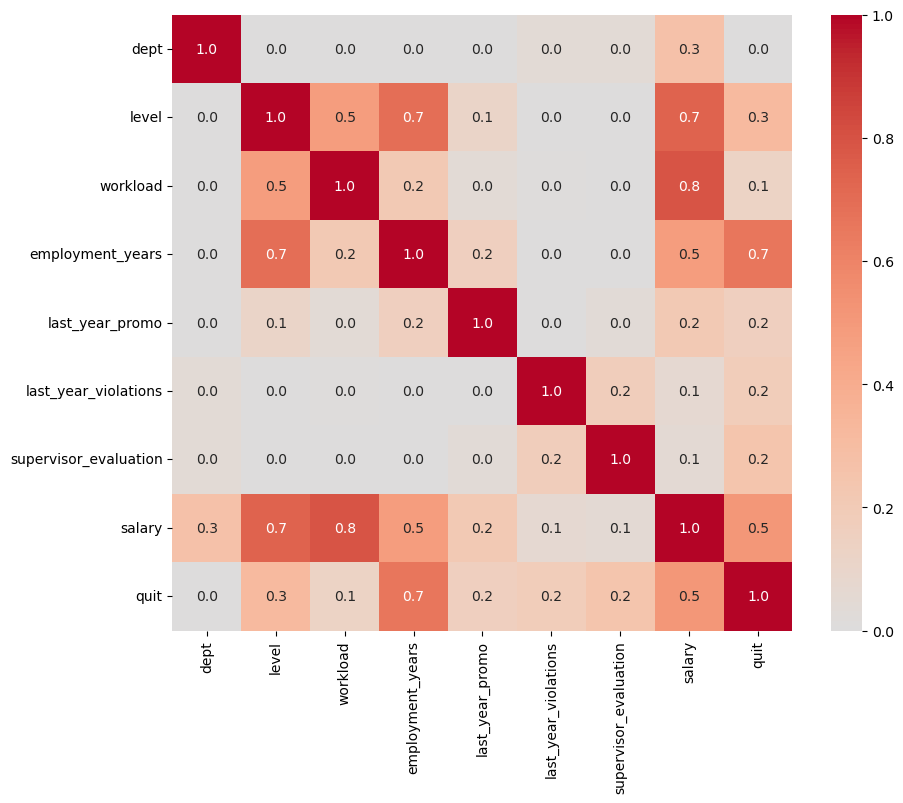

In [66]:
# уберем стобец id, так как он не несет смысла для корреляционного анализа
# применим функцию отрисовки корреляционных матриц, с необходимыми параметрами
train_corr = train_1.drop(['id'], axis=1)
u_interval_cols = ['salary']

print(' '*40 + 'Тренировочная выборка')
corr_heatmap(train_corr, u_interval_cols)

In [67]:
# создадим объединенную тестовую выборку
test_full_1=X_test_1.merge(y_test_1, on='id', how='left')

                                        Тренировочная выборка


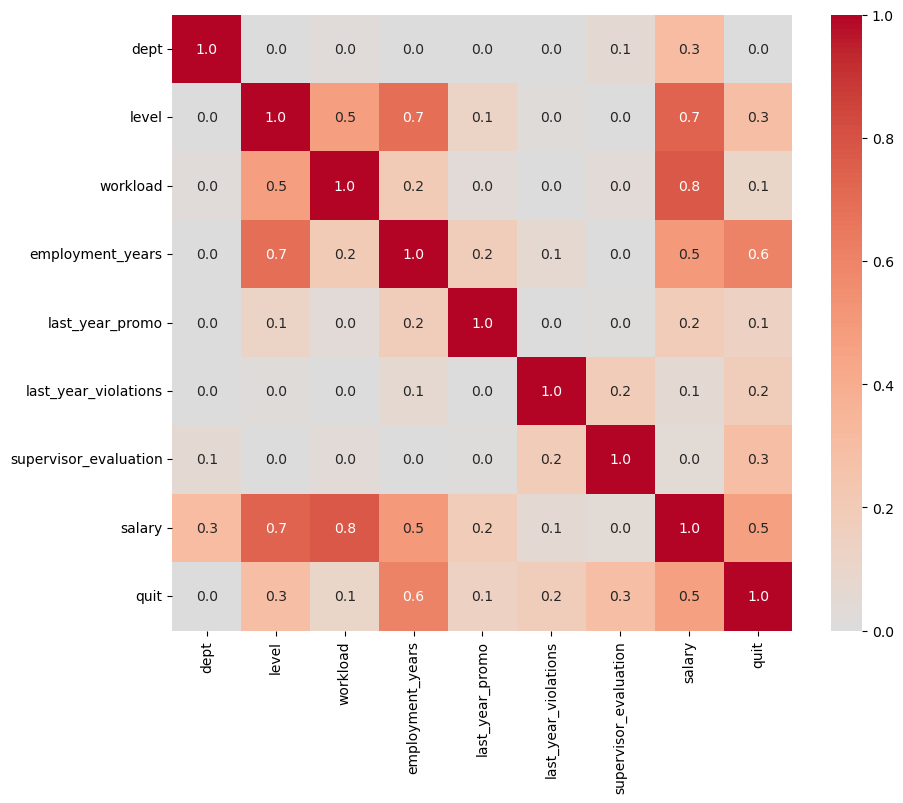

In [68]:
# уберем стобец id, так как он не несет смысла для корреляционного анализа
# применим функцию отрисовки корреляционных матриц, с необходимыми параметрами
test_corr = test_full_1.drop(['id'], axis=1)
u_interval_cols = ['salary']

print(' '*40 + 'Тренировочная выборка')
corr_heatmap(test_corr, u_interval_cols)

Можно сказать, что для тренировочной и тестовой выборок, корреляционные матрицы имеют схожий вид. Утечки целевого признака не обнаружено. Для всех, рассматриваемых признаков отрицательной корреляции не обнаружено. Целевой признак лучше всего коррелирует со стажем работы в комапнии и уровнем зарплаты. Можно отметить хорошую корреляцию между зарплатой и уровнем должности сотрудника, рабочей нагрузкой, трудовым стажем в компании. так же между уровнем должности и и стажем работы в компании.

#### Портрет "уволившегося сотрудника"

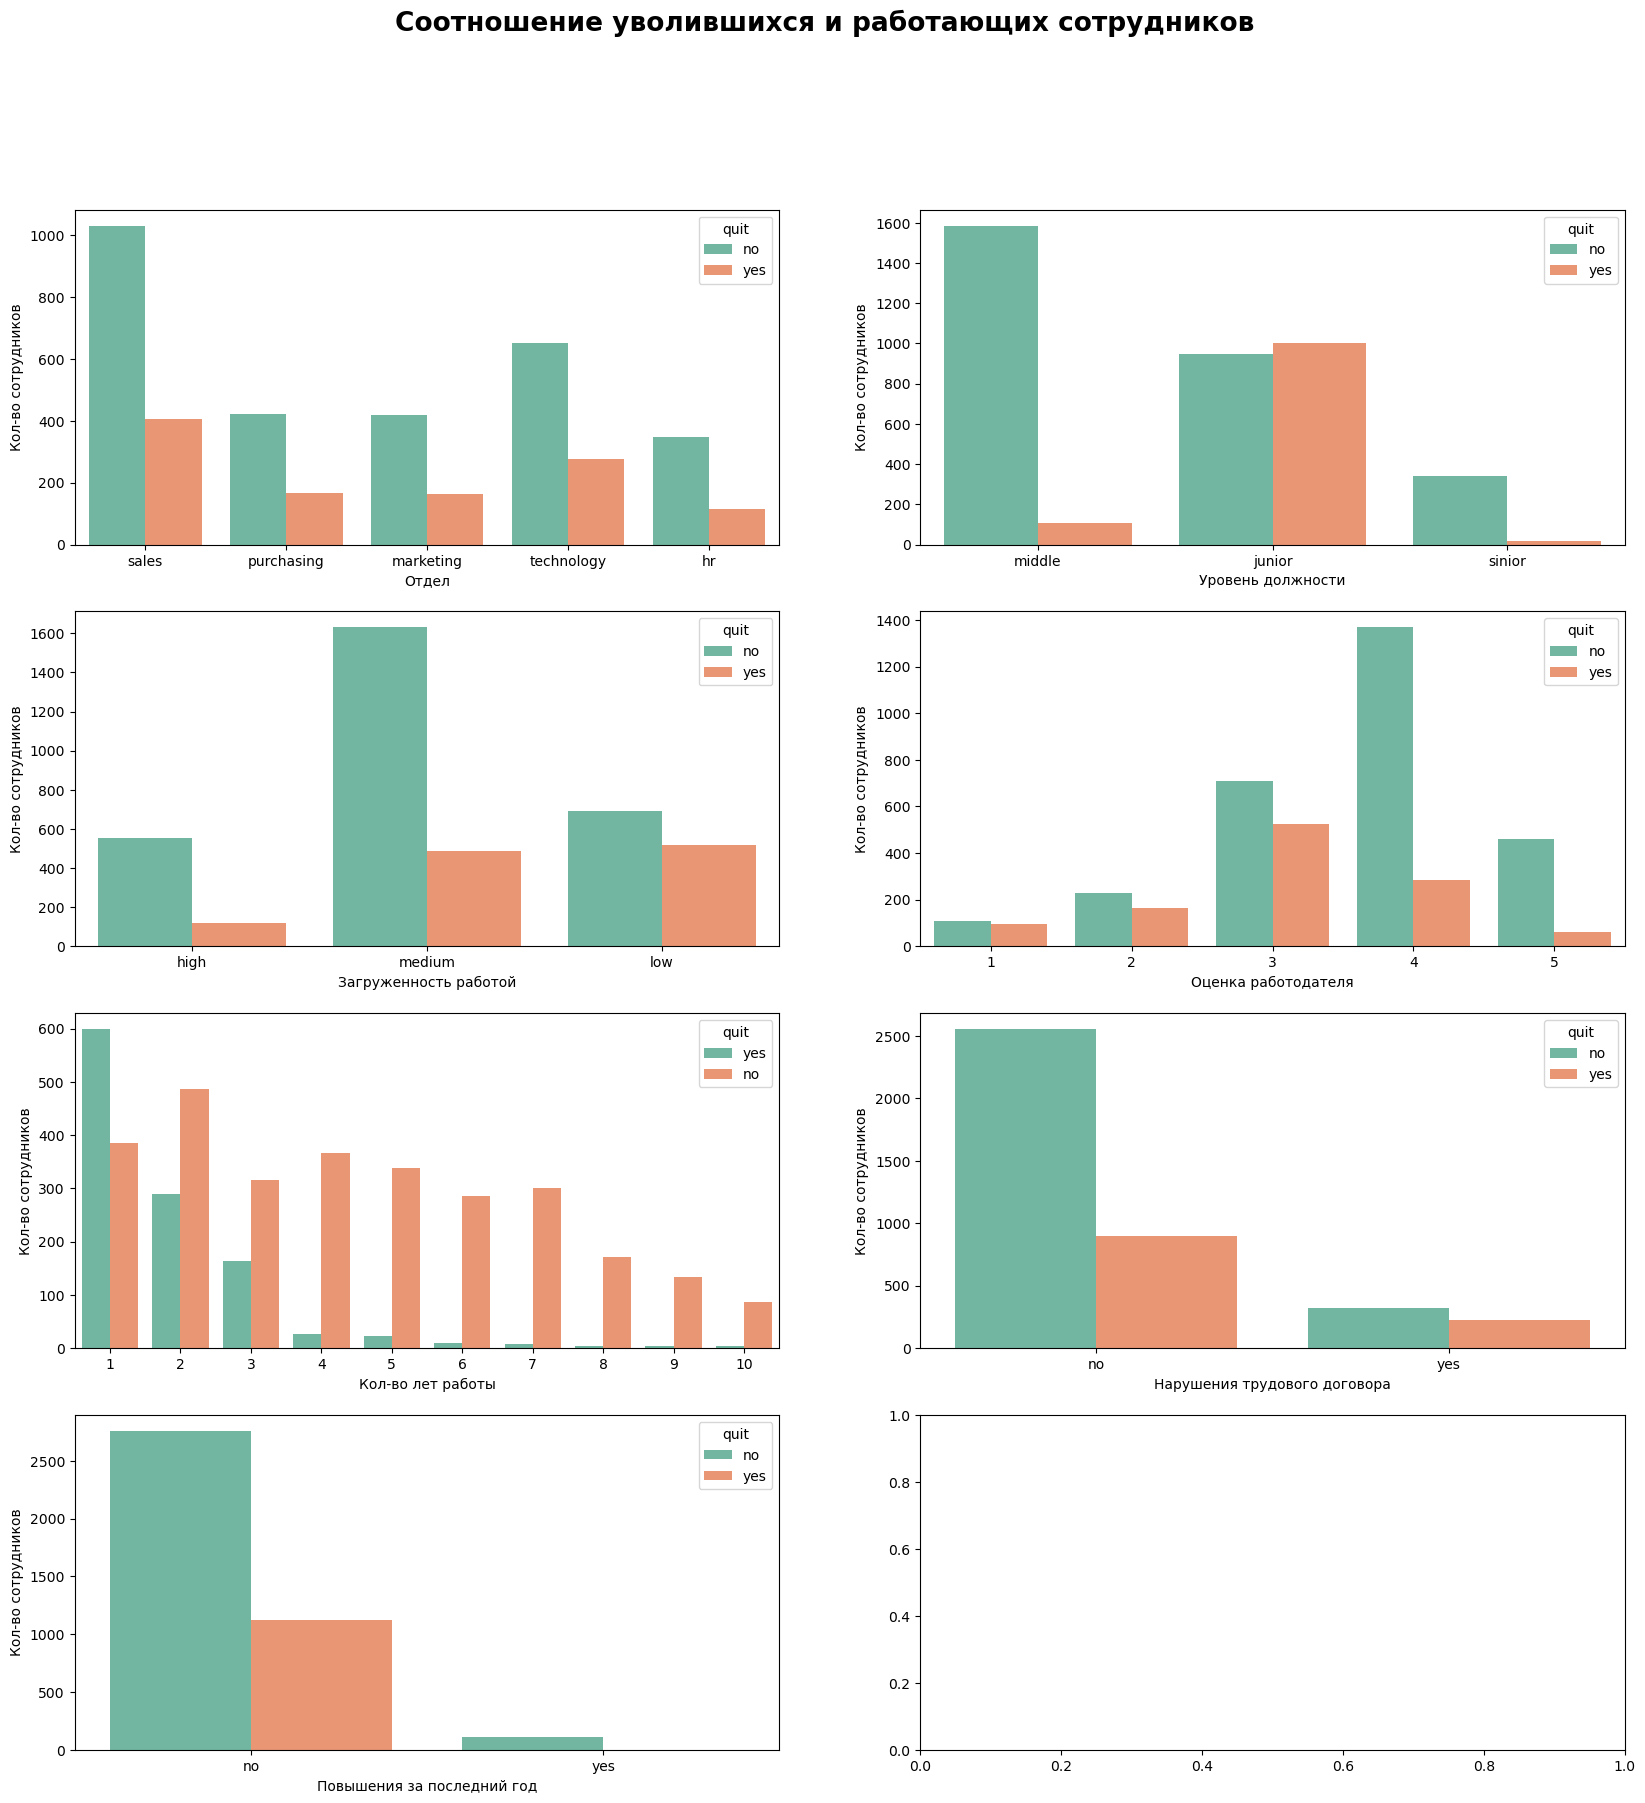

In [69]:
# визуализируем качественные и дискретные количественные признаки
fig, axes = plt.subplots(4, 2, figsize=(20,20))
plt.suptitle('Соотношение уволившихся и работающих сотрудников', fontsize=19, fontweight='bold')
sns.countplot(x ='dept', data = train_1, hue = 'quit',
              palette = "Set2", ax=axes[0,0]).set(xlabel='Отдел', ylabel='Кол-во сотрудников');
sns.countplot(x ='level', data = train_1, hue = 'quit',
              palette = "Set2", ax=axes[0,1]).set(xlabel='Уровень должности', ylabel='Кол-во сотрудников');
sns.countplot(x ='workload', data = train_1, hue = 'quit',
              palette = "Set2", ax=axes[1,0]).set(xlabel='Загруженность работой', ylabel='Кол-во сотрудников');
sns.countplot(x ='supervisor_evaluation', data = train_1, hue = 'quit',
              palette = "Set2", ax=axes[1,1]).set(xlabel='Оценка работодателя', ylabel='Кол-во сотрудников');
sns.countplot(x ='employment_years', data = train_1, hue = 'quit',
              palette = "Set2", ax=axes[2,0]).set(xlabel='Кол-во лет работы', ylabel='Кол-во сотрудников');
sns.countplot(x ='last_year_violations', data = train_1, hue = 'quit',
              palette = "Set2", ax=axes[2,1]).set(xlabel='Нарушения трудового договора', ylabel='Кол-во сотрудников');
sns.countplot(x ='last_year_promo', data = train_1, hue = 'quit',
              palette = "Set2", ax=axes[3,0]).set(xlabel='Повышения за последний год', ylabel='Кол-во сотрудников');

Средняя зарплата уволившегося сотрудника 37702.22841225627
Средняя зарплата работающего сотрудника 23885.106382978724


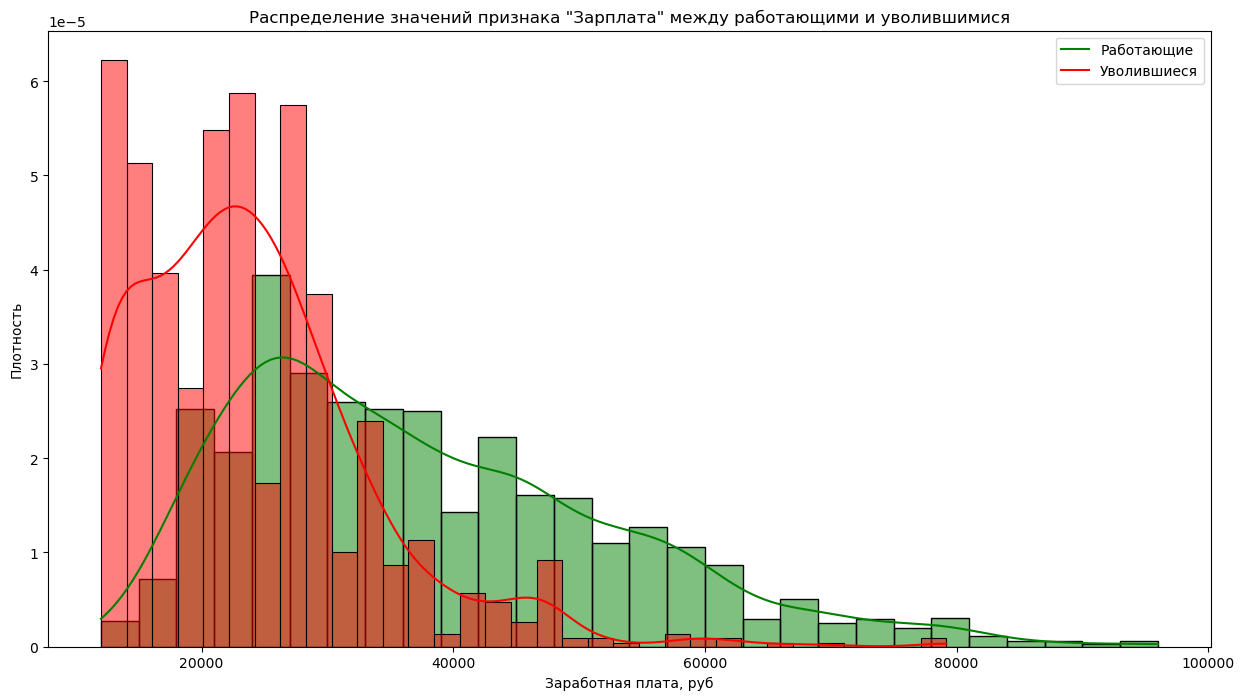

In [70]:
# посмотрим на непрерывный количественный признак
# вызовем функцию отрисовки двух наложенных диаграмм с нужными параметрами
u_x='salary'
u_labels= ['Работающие','Уволившиеся']
u_xlabel='Заработная плата, руб'
u_title='Распределение значений признака "Зарплата" между работающими и уволившимися'

overlay_hist(train_1.loc[train_1['quit']=='no'],
             train_1.loc[train_1['quit']=='yes'], u_x, u_labels, u_xlabel, u_title)

print('Средняя зарплата уволившегося сотрудника', 
      train_1.loc[train_1['quit']=='no']['salary'].mean())
print('Средняя зарплата работающего сотрудника', 
      train_1.loc[train_1['quit']=='yes']['salary'].mean())

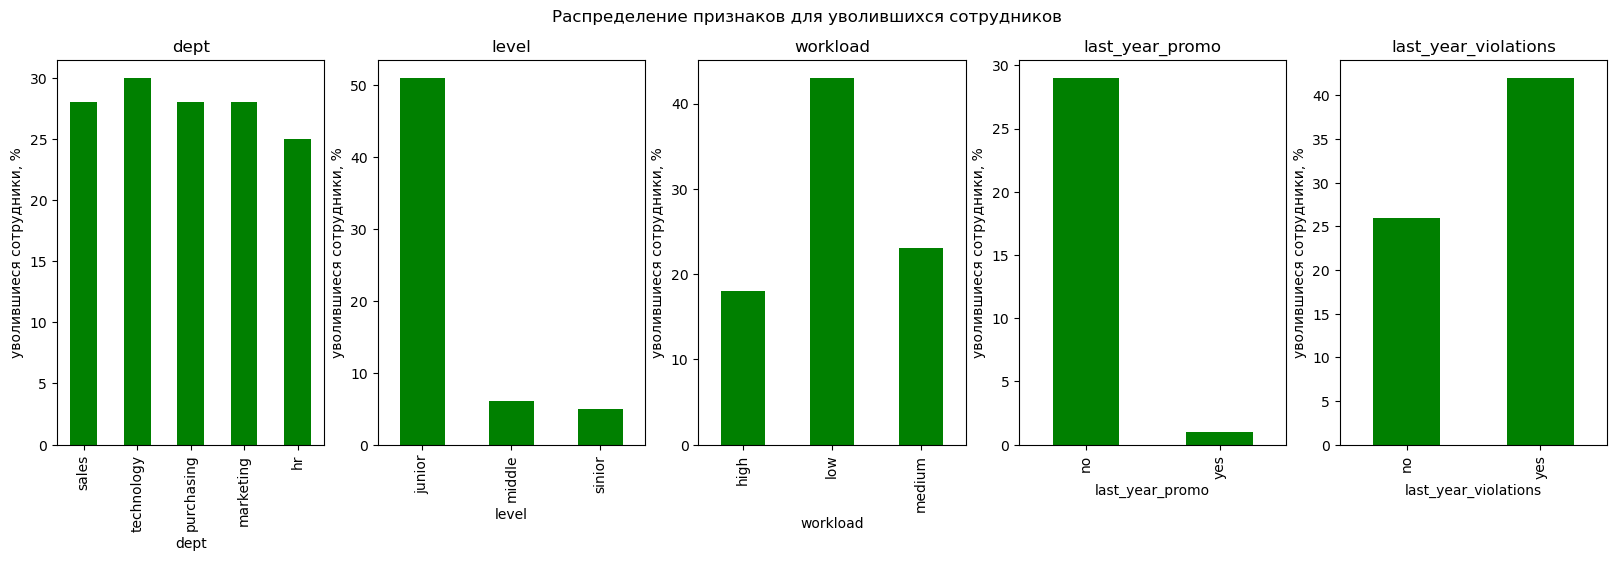

In [71]:
# посмотрим процент уволившихся сотрудников, относительно общего количества сотрдников
portrait_col=['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
fig, axs = plt.subplots(1, len(portrait_col), figsize=(20, 5))
plt.suptitle('Распределение признаков для уволившихся сотрудников')
for i, col in enumerate(portrait_col):
    round(100*train_1.loc[train_1['quit']=='yes'][col].value_counts()/train_1[col].value_counts()).plot(kind='bar',
                              ax=axs[i],
                              title = col, color='green',
                              ylabel='уволившиеся сотрудники, %')
plt.show();

Таким образом можно сказать, что чаще всего увольнялись сотрудники с уровнем должности джуниор, с низким уровнем загруженности, работавшие в компании менее 3-х лет, имеющие оценку руководителя менее 3, часто нарушающие трудовой договор и не получавшие повышения за последний год. Средняя зарплата уволившегося сотрудника была порядка 24 тыс. руб. Средняя зарплата уволившихся сотрудником на 35% ниже чем у сотрудников, продолживших работать в компании.

#### Влияние признака job_satisfaction_rate на принятие решения об увольнении

Проверим утврждение коллег аналитиков о влиянии признака удовлетворенности работой на принятие решения об увольнении.

Проверим идентичны ли тестовые выборки целевого признака по столбцу id

In [72]:
y_test_old['id'].isin(y_test_1['id']).sum()

2000

In [73]:
# теперь можно соединить данные выборки
test_two_target = y_test_old.merge(y_test_1, on='id')
test_two_target

,id,job_satisfaction_rate,quit
0,130604,0.74,no
1,825977,0.75,no
2,418490,0.60,yes
3,555320,0.72,no
4,826430,0.08,yes
...,...,...,...
1995,405257,0.28,no
1996,370925,0.21,yes
1997,857722,0.39,no
1998,303402,0.26,yes


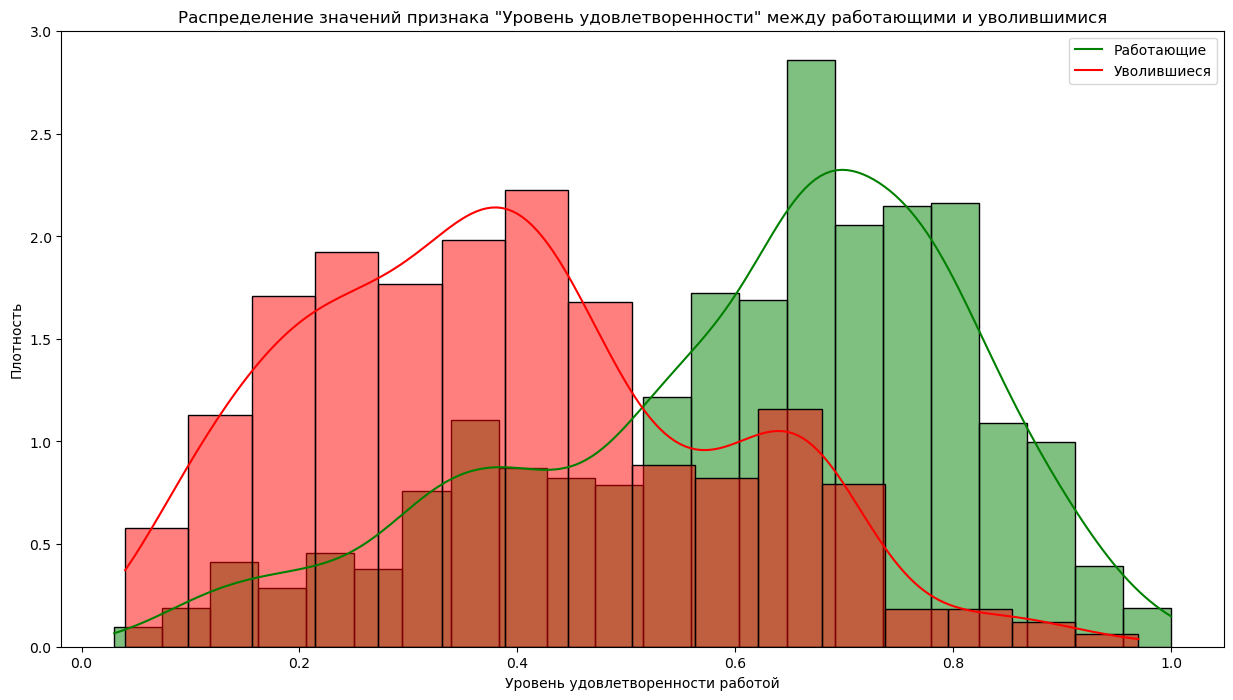

In [74]:
# постоим распределение
u_x='job_satisfaction_rate'
u_labels= ['Работающие','Уволившиеся']
u_xlabel='Уровень удовлетворенности работой'
u_title='Распределение значений признака "Уровень удовлетворенности" между работающими и уволившимися'
overlay_hist(test_two_target[test_two_target['quit']=='no'],
             test_two_target[test_two_target['quit']=='yes'], u_x, u_labels, u_xlabel, u_title)

Коллеги правы, наблюдается определенная зависмость - большинство уволившихся сотрудников имели уровень удовлетворенности работой менее 0.5

### Добавление нового входного признака

Добавим job_satisfaction_rate как новый входящий признак в тренировочную и тестовую выборки

In [75]:
# сохраним выборки перед преобразованиями
train_1_old = train_1.copy()
X_test_1_old = X_test_1.copy()

In [76]:
# переведем id в индексы
train_1 = train_1.set_index('id', drop=True)

In [77]:
# добавим столбец job_satisfaction_rate_pred в тренировочную выборку, на основе предсказания лучшей модели
train_1['job_satisfaction_rate_pred'] = randomized_search.best_estimator_.predict(train_1.drop(['quit'], axis=1))
train_1.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate_pred
id,,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no,0.600000
814010,sales,junior,medium,2,no,no,4,27600,no,0.846364
155091,purchasing,middle,medium,5,no,no,1,37200,no,0.340000
257132,sales,junior,medium,2,no,yes,3,24000,yes,0.340000
910140,marketing,junior,medium,2,no,no,5,25200,no,0.785000


In [78]:
# переведем id в индексы
test_full_1 = test_full_1.set_index('id', drop=True)
test_full_1

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,no
686555,hr,junior,medium,1,no,no,4,30000,no
467458,sales,middle,low,5,no,no,4,19200,no
418655,sales,middle,low,6,no,no,4,19200,no
789145,hr,middle,medium,5,no,no,5,40800,no
...,...,...,...,...,...,...,...,...,...
393147,marketing,junior,low,3,no,no,3,20400,yes
109582,technology,middle,low,3,no,no,2,21600,yes
305653,technology,junior,low,1,no,no,3,14400,yes


In [79]:
# добавим столбец job_satisfaction_rate_pred в тестовую выборку, на основе предсказания лучшей модели
test_full_1['job_satisfaction_rate_pred'] = randomized_search.best_estimator_.predict(test_full_1.drop(['quit'], axis=1))
test_full_1.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate_pred
id,,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,no,0.885000
686555,hr,junior,medium,1,no,no,4,30000,no,0.681429
467458,sales,middle,low,5,no,no,4,19200,no,0.654000
418655,sales,middle,low,6,no,no,4,19200,no,0.655000
789145,hr,middle,medium,5,no,no,5,40800,no,0.787500


Новые признаки добавлены.

### Подготовка данных 

Основываясь на результатах, проведенного осмотра данных и результатах исследовательского анализа, проведем предобработку данных, по следующему плану:

- удалим признак id в выборках, как не несущий информации для моделирования. в тренировочной выборке, после удаления
- нужно будет проверить выборку на дубликаты, в случае их наличия - удалить;
- разделить выборки на входящие и целевой признаки;
- Количественные признаки: employment_years, supervisor_evaluation, salary и job_satisfaction_rate_pred. Необходимо будет масштабировать;
- Качественные признаки: last_year_promo и last_year_violations. Кодируем OneHotEncoder;
- Качественные признаки: dept, level и workload. Кодируем OrdinalEncoder;
- целевой признак теперь категориальный, поэтому нужно будет его кодировать методом LabelEncoder.

#### Удаление признака id, проверка дубликатов

In [80]:
# в тренировочной выборке мы уже фактически удалили id переведя его в индексы
# проверяем дубликаты
train_1.duplicated().sum()

1413

In [81]:
# удаляем дубликаты
train_1 = train_1.drop_duplicates().reset_index(drop=True)

# проверяем
train_1.shape

(2587, 10)

#### Разделение выборок на входящие и целевые признаки

In [82]:
# разделяем тренировочную выборrу
X_train_1 = train_1.drop(['quit'], axis=1)
y_train_1 = train_1['quit']

# проверим
X_train_1.shape, y_train_1.shape

((2587, 9), (2587,))

In [83]:
# разделяем тренировочную выборrу
X_test_1 = test_full_1.drop(['quit'], axis=1)
y_test_1 = test_full_1['quit']

# проверим
X_test_1.shape, y_test_1.shape

((2000, 9), (2000,))

#### Создание пайплайна предобработки

In [84]:
# кодируем целевой признак
label_encoder = LabelEncoder()
y_train_1 = label_encoder.fit_transform(y_train_1)
y_test_1 = label_encoder.transform(y_test_1)

In [85]:
# определим списки по типам параметров
ohe_columns = ['last_year_promo', 'last_year_violations']
ord_columns = ['dept', 'level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate_pred']

In [86]:
# создаем пайплайн для ohe

ohe_pipe = Pipeline(
    [('simpleImputer_ohe_nan', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('simpleImputer_ohe_', SimpleImputer(missing_values=' ', strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='error'))
    ]
)

In [87]:
# создаем пайплайн для ord

ord_pipe = Pipeline(
    [('simpleImputer_before_ord_nan', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('simpleImputer_before_ord_', SimpleImputer(missing_values=' ', strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['sales', 'hr', 'technology', 'purchasing', 'marketing'],
                    ['junior', 'middle', 'sinior'],
                    ['low','medium', 'high']
                ],
                handle_unknown= 'use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [88]:
# создаём общий пайплайн для подготовки данных

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [89]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier())
]
)

### Обучение моделей

In [90]:
# список для оцещика
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 9),
        'models__max_features': range(2,9),
        'models__min_samples_split': range(2, 15),
        'models__min_samples_leaf': range(1, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    # словарь для модели KNeighborsClassifier()
        {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__C': [0.01,1,10],
        'models__kernel': ['linear', 'poly', 'rbf'],
        'models__degree': ['1', '2', '3', '4']

    }
]

In [91]:
# оценщик
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train_1, y_train_1)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe_nan',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('simpleImputer_ohe_',
                                                                   SimpleImputer(missing_values=' ',
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['last_year_promo',
                                                   'last_year_violations'])

In [92]:
quit_test_pred_proba = randomized_search.predict_proba(X_test_1)[:, 1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_1, quit_test_pred_proba)}')

Метрика ROC-AUC на тестовой выборке: 0.917907554475592


Таким образом видим, что лучшая модель DecisionTreeClassifier(max_depth=7, max_features=5, min_samples_leaf=6, min_samples_split=8). Метрика ROC-AUC на тестовой выборке получилась 0.9179. 

## Общий вывод

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён.

Задачами работы являлись:

- построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.
- построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

Целевой признак для первой задачи - job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, моделирование необходимо выполнять методами регрессии. Целевой признак для второй задачи - quit — увольнение сотрудника из компании, моделирование необходимо выполнять методами классификации.

==============================================================================================================
Задача 1:
- все данные загрузились корректно;
- размерность тренировочного датафрейма: 10 стобцов / 4000 строк; размерность тестового датафрейма входящих признаков: 9 стобцов / 2000 строк; размерность тестового датафрейма целевого признака: 2 стобца / 2000 строк.
- во всех датафреймах: типы данных корректны, отстуствуют явные и неявные дубликаты, названия столбцов корректны, отстутсвуют отрицательные значения в числовых столбцах;
- наблюдается небольшое количество пропусков в качественных признаках, их доля менее 0.5% от всего объема данных, для конткретного датафрейма;
- в некоторых числовых столбцах присутствую логичные выбросы: зарплата и оценка руководителя;
__________________________________________________________________________
- пропуски в данных были заполнены наиболее часто встречающимися значениями;
- все признаки имеют схожие распределения для тренировочного и тестовых выборок;
- распределения целевого признака и величины зарплаты отличны от нормального;
___________________________________________________________________________
- преобладает количество сотрудников, которые работают в компании 1-2 года;
- руководители чаще всего оценивают работу сотрудников на 3 и 4;
- самая частая зарплата 30 000;
- больше всего сотрудников имеют уровень junior и middle;
- больше всего сотрудников оценивают свою трудовую нагрузку как среднюю;
- повышение за последний год получили 3% сотрудников;
- менее 15% сотрудников нарушали трудовой догвор за последний год;
- целевой признак лучше всего коррелирует с оценкой руководителя и наличием фактов нарушения трудового договора. Можно отметить хорошую корреляцию между зарплатой и уровнем должности сотрудника, рабочей нагрузкой, трудовым стажем в компании;
______________________________________________________________________________
- для предсказания параметра удовлетворенности сотрудника наилучший результат показала модель: DecisionTreeRegressor(max_depth=30, max_features=5, min_samples_split=5)
- Метрика SMAPE на тестовой выборке получилась 14.216.

=================================================================================================================
Задача 2:
- все данные загрузились корректно;
- размерность тренировочного датафрейма: 10 стобцов / 4000 строк; размерность тестового датафрейма входящих признаков: 9 стобцов / 2000 строк; размерность тестового датафрейма целевого признака: 2 стобца / 2000 строк.
- во всех датафреймах: типы данных корректны, отстуствуют явные и неявные дубликаты, названия столбцов корректны, отстутсвуют отрицательные значения в числовых столбцах;
- наблюдается небольшое количество пропусков в качественных признаках, их доля менее 0.5% от всего объема данных, для конткретного датафрейма;
- в некоторых числовых столбцах присутствую логичные выбросы: зарплата и оценка руководителя;
__________________________________________________________________________
- пропуски в данных были заполнены наиболее часто встречающимися значениями;
- все признаки имеют схожие распределения для тренировочного и тестовых выборок;
- распределение величины зарплаты отличны от нормального;
___________________________________________________________________________
- преобладает количество сотрудников, которые работают в компании 1-2 года;
- руководители чаще всего оценивают работу сотрудников на 3 и 4;
- самая частая зарплата 30 000;
- больше всего сотрудников имеют уровень junior и middle;
- больше всего сотрудников оценивают свою трудовую нагрузку как среднюю;
- повышение за последний год получили 3% сотрудников;
- менее 15% сотрудников нарушали трудовой догвор за последний год;
- целевой признак лучше всего коррелирует со стажем работы в комапнии и уровнем зарплаты. Можно отметить хорошую корреляцию между зарплатой и уровнем должности сотрудника, рабочей нагрузкой, трудовым стажем в компании. так же между уровнем должности и и стажем работы в компании;
_______________________________________________________________________________________
- портрет уволившегосы сотрудника: сотрудники с уровнем должности джуниор, с низким уровнем загруженности, работавшие в компании менее 3-х лет, имеющие оценку руководителя менее 3, часто нарушающие трудовой договор и не получавшие повышения за последний год. Средняя зарплата уволившегося сотрудника была порядка 24 тыс. руб. Средняя зарплата уволившихся сотрудником на 35% ниже чем у сотрудников, продолживших работать в компании;
- большинство уволившихся сотрудников имели уровень удовлетворенности работой менее 0.5;
- в тринировочную выборку был добавлен новый входящий признак job_satisfaction_rate;
______________________________________________________________________________
- для предсказания увольнения сотрудника наилучший результат показала модель: DecisionTreeClassifier(max_depth=7, max_features=5, min_samples_leaf=6, min_samples_split=8);
- Метрика ROC-AUC на тестовой выборке получилась 0.9179.
___________________________________________________________________________________
**Возможные рекомендации:** необходимо обратить внимание на удовлетворенность работников уровня джуниор, возможно разработать более адекватный подход к карьерному треку молодых специалистов в компании, чаще проводить оценку качества их работы и менее инерционно принимать решение о повышении. В большей степени именно джуниоры, не получавшие повышени, а значит и прироста зарплаты, были недовлетворены работой в компании. С этим же связанно и нарушение трудового договора. При этом уволившиеся сотрудники, зачастую получали от руководителя на уровне 3-4 балла, это говорит о том, что в среднем работодатель был удовлетворен уровнем данных специалистов.